###Intro:

L'objectif de ce projet est de développer un modèle d'apprentissage profond capable de classer avec précision les expressions faciales dans l'une des sept catégories suivantes : Colère, Dégoût, Peur, Joie, Tristesse, Surprise, et Neutre. Nous utiliserons des réseaux de neurones convolutifs (CNN) pour entraîner notre modèle, car ils ont montré leur efficacité dans les tâches de classification d'images. Notre approche consiste à entraîner un modèle CNN à partir de zéro sur le jeu de données FER-2013.



###data:

Le jeu de données FER-2013 se compose d'images en niveaux de gris de visages de 48x48 pixels, qui ont été automatiquement enregistrées pour être centrées et occuper une surface similaire dans chaque image. Le jeu de données contient 24 400 images, avec 22 968 exemples dans l'ensemble d'entraînement et 1 432 exemples dans l'ensemble de test public.

## 1-Importer les bibliothèques nécessaires pour travailler

In [55]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input,ZeroPadding2D,Resizing,Rescaling
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


## 2 -- Chargement des données

Les données consistent en des images en niveaux de gris de visages de 48x48 pixels. Les visages ont été automatiquement enregistrés de sorte que le visage soit plus ou moins centré et occupe à peu près la même quantité d'espace dans chaque image. La tâche consiste à catégoriser chaque visage en fonction de l'émotion exprimée dans l'expression faciale, dans l'une des sept catégories suivantes :

emotion_labels = {
    'Anger': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happy': 3,
    'Sad': 4,
    'Surprise': 5,
    'Neutral': 6
}

------------------------------------------------------------------------

La commande !pip install gdown installe la bibliothèque gdown pour télécharger des fichiers depuis Google Drive.
import gdown permet d'utiliser cette bibliothèque dans le script Pytho

In [2]:
!pip install gdown
import gdown

Ce code télécharge un fichier depuis Google Drive en utilisant l'ID du fichier et le sauvegarde sous le nom data.csv. La fonction gdown.download gère le téléchargement à partir de l'URL construite avec l'ID du fichier.

In [3]:
# File ID and URL
file_id = "1XIqVjGsjnDog-FRk72ew8byD99ekBt-k"
url = f"https://drive.google.com/uc?id={file_id}"

# Destination filename
output = "data.csv"  # You can name the file anything, keeping the .csv extension

# Download the file
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1XIqVjGsjnDog-FRk72ew8byD99ekBt-k
From (redirected): https://drive.google.com/uc?id=1XIqVjGsjnDog-FRk72ew8byD99ekBt-k&confirm=t&uuid=91ecb382-057d-4769-a3ce-9d8c65396c4e
To: /content/data.csv
100%|██████████| 301M/301M [00:05<00:00, 54.6MB/s]


'data.csv'

charge le fichier data.csv dans un DataFrame pandas, permettant de manipuler et analyser les données contenues dans ce fichier CSV.

In [4]:
data = pd.read_csv("data.csv")

## 3-- Exploration des données  :

L'exploration des données consiste à analyser les données pour en comprendre la structure, les tendances et les anomalies. Cela inclut des actions comme le résumé statistique, la visualisation

### 3.1- Résumé statistique

#### a-Comptage des émotions dans les données

In [ ]:
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

count_emotions = (data.groupby(data['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotion_mapping[k] for k in emotion_mapping.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprise
6,6198,Neutral


#### b-Dimensions du jeu de données

In [ ]:
data.shape

(35887, 3)

#### c-Résumé statistique et informations sur le jeu de données

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
#get mean and min and max...
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


#### d-Répartition des données par type d'utilisation

In [ ]:
data['Usage'].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


### 3.2- Visualisation des données

#### a-Aperçu des premières lignes du jeu de données

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#### b-Distribution des émotions dans le jeu de données

Ce code génère un graphique à barres pour visualiser la distribution des différentes émotions dans le jeu de données, en associant des étiquettes aux valeurs numériques des émotions et en réarrangeant l'ordre des émotions aléatoirement.

In [ ]:
import plotly.express as px
import pandas as pd

# Load your dataset
data_plot = pd.read_csv("data.csv")

# Define the class labels and a mapping
CLASS_LABELS1 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
emotion_map = {i: label for i, label in enumerate(CLASS_LABELS1)}

# Map numeric emotion values to class labels
data_plot['emotion_labels'] = data_plot['emotion'].map(emotion_map)

# Count the occurrences of each emotion (unordered)
emotion_counts = data_plot['emotion_labels'].value_counts()

# Shuffle the order of labels randomly (or use a specific order you want)
emotion_counts = emotion_counts.sample(frac=1)  # `frac=1` shuffles the rows

# Create the bar chart
fig1 = px.bar(
    x=emotion_counts.index,
    y=emotion_counts.values,
    color=emotion_counts.index,
    color_continuous_scale="Emrld"
)

# Update axes titles and layout
fig1.update_xaxes(title="Emotions")
fig1.update_yaxes(title="Number of Images")
fig1.update_layout(
    showlegend=AC,
    title={
        'text': 'Data Distribution',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Show the figure
fig1.show()



#### c-Distribution des émotions selon les types d'utilisation

Ce code crée un graphique à barres empilées pour visualiser la répartition des émotions dans différents types d'utilisation (Entraînement, Test Public, Test Privé), avec des étiquettes d'émotions et des emojis associés.

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming you have already loaded the data_plotset into a data_plotFrame 'data'
# Example data structure

# Load your dataset
data_plot3 = pd.read_csv("data.csv")

# Grouping by 'Usage' and 'emotion' and counting occurrences
usage_emotion_counts = data_plot3.groupby(['Usage', 'emotion']).size().reset_index(name='count')

# Mapping emotion indices to emotion names and emojis
CLASS_LABELS = ['Anger 😡', 'Disgust 🤢', 'Fear 😨', 'Happy 😊', 'Neutral 😐', 'Sadness 😢', 'Surprise 😲']
usage_emotion_counts['emotion_label'] = usage_emotion_counts['emotion'].map(lambda x: CLASS_LABELS[x])

# Plot the data_plot using Plotly
fig3 = px.bar(usage_emotion_counts,
             x='emotion_label', y='count',
             color='Usage',
             title='Emotion Distribution Across Different Usage Types',
             labels={'emotion_label': 'Emotion', 'count': 'Number of Images', 'Usage': 'Usage Type'},
             barmode='stack')

# Customize layout
fig3.update_layout(
    xaxis_title="Emotion",
    yaxis_title="Number of Images",
    showlegend=True,
    title={'text': 'Emotion Distribution in Training, PublicTest, and PrivateTest', 'x': 0.5, 'xanchor': 'center'}
)

# Show the plot
fig3.show()


#### d-Distribution des émotions sous forme de graphique circulaire

Ce code génère un graphique circulaire pour visualiser la répartition des émotions dans le jeu de données, en mappant les valeurs numériques des émotions aux étiquettes correspondantes et en affichant les pourcentages pour chaque émotion.

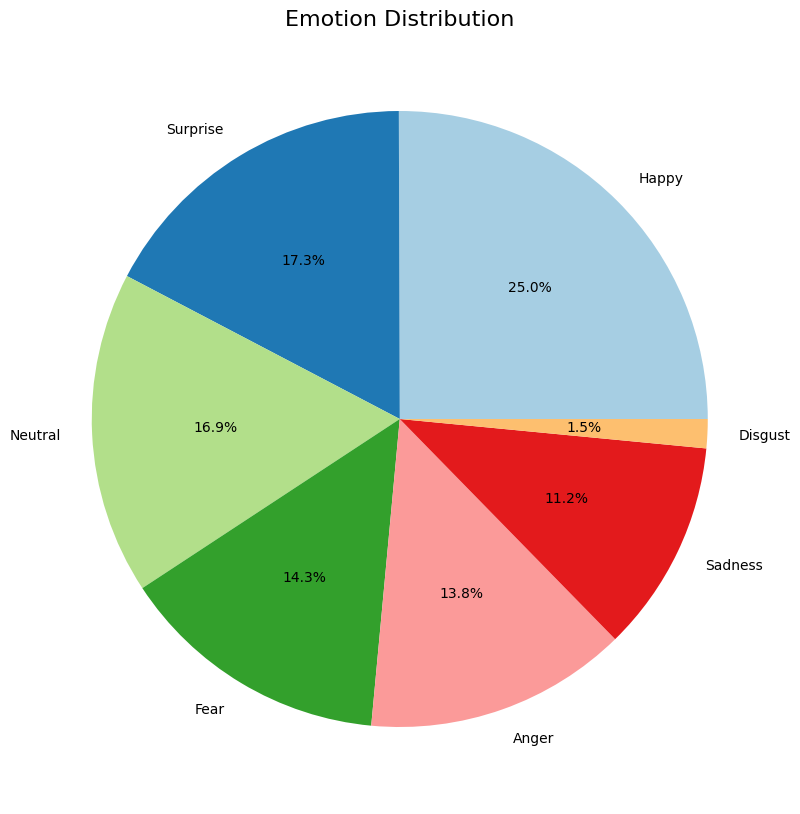

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_pl = pd.read_csv("data.csv")
# Define the CLASS_LABELS
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Replace the emotion column with the CLASS_LABELS (if it's a numeric code or map to the appropriate class)
# Ensure that your 'emotion' column contains the correct values corresponding to the emotion classes.
# If 'emotion' is already categorical or string type, you may not need this step.
# Assuming data['emotion'] is an index or numeric code, we can map them as follows:

# Create a dictionary to map numerical values to emotion labels
emotion_map = {i: label for i, label in enumerate(CLASS_LABELS)}

# If 'data['emotion']' contains numerical values (e.g., 0, 1, 2, 3, ...), we can map them to the labels
data_pl['emotion'] = data_pl['emotion'].map(emotion_map)

# Now, plot the pie chart
country_counts = data_pl['emotion'].value_counts()

# Plot
plt.figure(figsize=(12, 10))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts))))
plt.title('Emotion Distribution', fontsize=16)
plt.show()


#### e-Répartition des données par type d'utilisation

Ce code génère un graphique à barres pour visualiser la répartition des données selon les différents types d'utilisation dans la colonne "Usage", en comptabilisant le nombre d'occurrences pour chaque type.

In [ ]:
import pandas as pd
import plotly.express as px



# Count the number of occurrences for each label in the 'Usage' column
usage_counts = data['Usage'].value_counts().reset_index()
usage_counts.columns = ['Usage', 'Count']

# Create a bar chart using Plotly
fig = px.bar(usage_counts, x='Usage', y='Count', title="Distribution of Labels in Usage Column", color='Usage')

# Update axes titles and layout
fig.update_xaxes(title="Usage Type")
fig.update_yaxes(title="Number of Instances")
fig.update_layout(showlegend=False)

# Show the plot
fig.show()


#### f-Nombre de chaque étiquette d'émotion dans les différentes catégories d'utilisation

Ce code génère un graphique à barres empilées pour visualiser le nombre d'images associées à chaque étiquette d'émotion dans les différentes catégories d'utilisation (Entraînement, Test Public, Test Privé). Les émotions sont mappées à partir de valeurs numériques et comptées pour chaque type d'utilisation.

In [ ]:
import pandas as pd
import plotly.express as px

# Load your data_plot2set
data_plot2 = pd.read_csv("data.csv")

# Define the class labels and create a mapping
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
emotion_map = {i: label for i, label in enumerate(CLASS_LABELS)}

# Map numeric emotion values to class labels
data_plot2['emotion_labels'] = data_plot2['emotion'].map(emotion_map)

# Group by 'Usage' and count occurrences of each 'emotion_labels' within each usage category
usage_emotion_counts = data_plot2.groupby(['Usage', 'emotion_labels']).size().unstack(fill_value=0)

# Reset the index to have 'Usage' as a column
usage_emotion_counts = usage_emotion_counts.reset_index()

# Plot the result using Plotly for better visualization
fig = px.bar(
    usage_emotion_counts,
    x='Usage',
    y=usage_emotion_counts.columns[1:],  # All columns except the first one (Usage)
    title="Number of Each Emotion Label in Different Usage Categories",
    labels={'value': 'Number of Images', 'emotion_labels': 'Emotion'},
    barmode='stack'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Usage Type",
    yaxis_title="Number of Instances",
    legend_title="Emotion Label"
)

# Show the plot
fig.show()


#### g-Visualisation des échantillons d'émotion

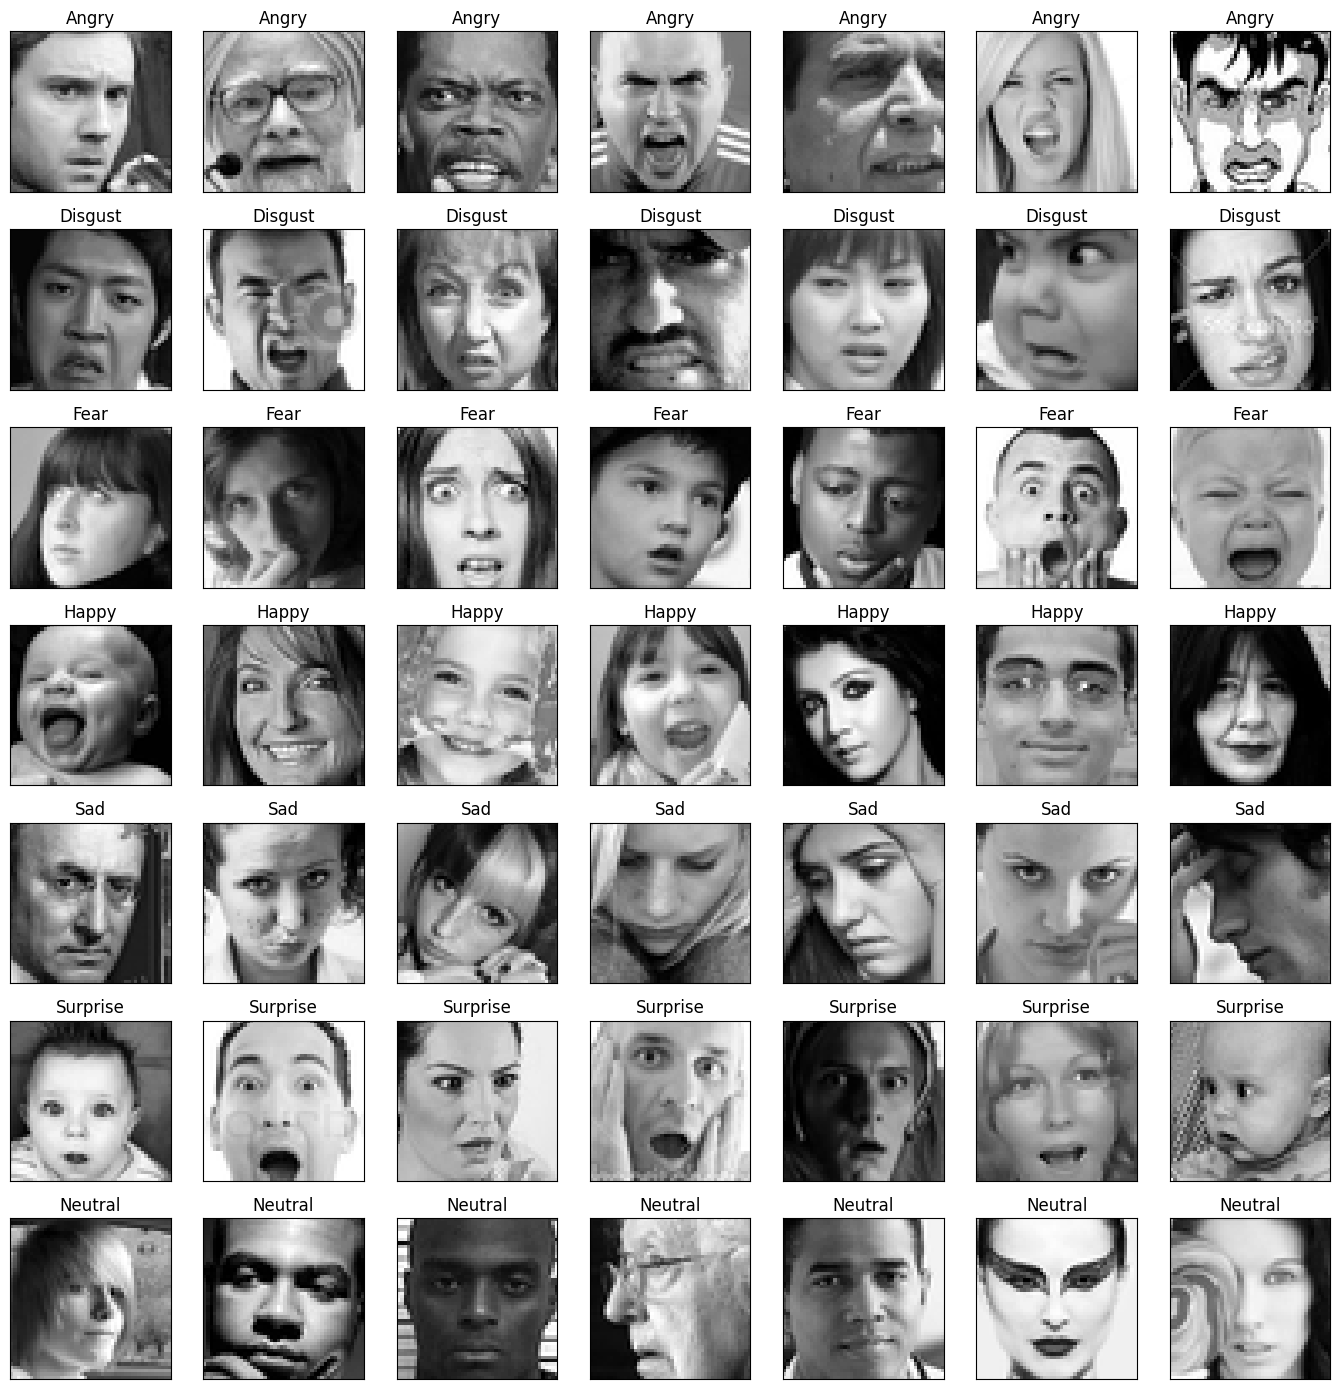

In [ ]:
from matplotlib import pyplot
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_mapping[label])
        pyplot.tight_layout()

## 4 -- Prétraitement des données

Introduction :

-Cette section présente les étapes essentielles pour préparer les données en vue de l'entraînement d'un modèle CNN pour la détection des émotions humaines à partir du jeu de données FER-2013. Nous commencerons par la gestion des données manquantes, la conversion des pixels en tableaux NumPy, la normalisation, le redimensionnement et l'augmentation des données.

-De plus, pour optimiser l'entraînement du modèle, nous utiliserons des générateurs de données afin de charger les images en petits lots, ce qui permet de gérer efficacement la taille et la complexité du jeu de données. Nous appliquerons également diverses techniques d'augmentation des données, telles que la rotation, le décalage et le retournement, afin d'enrichir l'ensemble d'entraînement. Ces techniques visent à améliorer la performance du modèle tout en réduisant le risque de sur-apprentissage, garantissant ainsi une meilleure généralisation sur de nouvelles données.

### a. Gestion des données manquantes

Après avoir analysé le dataset à l'aide des fonctions msno.bar et isnull(), il a été constaté qu'il n'y a aucune valeur manquante dans les colonnes, ce qui indique que le dataset est complet.

In [5]:
#checking missing values
data.isnull().sum()

,0
emotion,0
pixels,0
Usage,0


msno.bar(data) génère un graphique en barres pour visualiser les valeurs manquantes dans chaque colonne du DataFrame data

<Axes: >

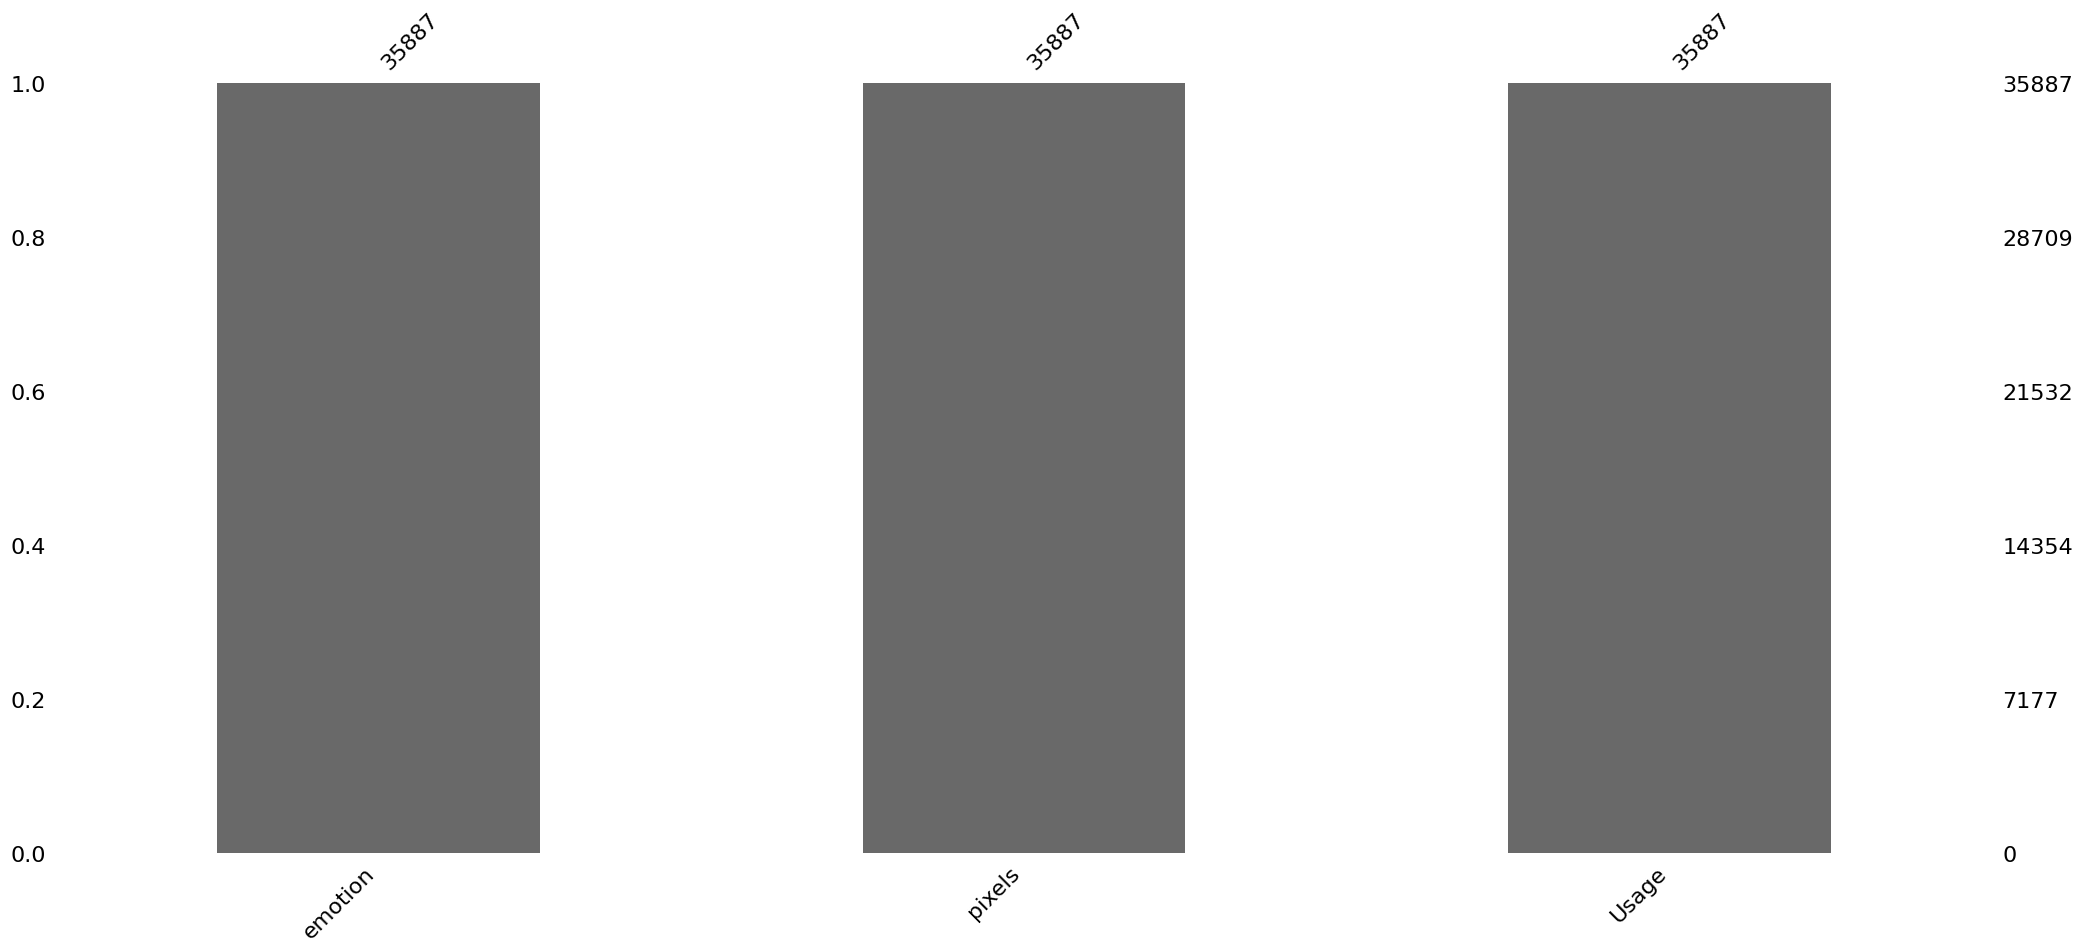

In [6]:
import missingno as msno
msno.bar(data)

### b. Diviser les données en fonction de la colonne d'utilisation

In [7]:
# Split the dataset into training, validation, and testing based on the 'Usage' column
train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PublicTest']  # Or 'PrivateTest' based on your need
test_data = data[data['Usage'] == 'PrivateTest']  # If you have a separate validation set

# Check the split
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (28709, 3)
Testing data shape: (3589, 3)
Validation data shape: (3589, 3)


### c. Convertir les pixels d'image en tableaux NumPy

In [8]:
# Convert the 'pixels' column into NumPy arrays
def convert_pixels(dataset):
    return np.array(list(map(str.split, dataset['pixels'])), dtype=np.float32)

train_data_arr = convert_pixels(train_data)
val_data_arr = convert_pixels(val_data)
test_data_arr = convert_pixels(test_data)

print("Shape of raw pixel arrays:")
print("X_train:",train_data_arr.shape)
print("X_val:", val_data_arr.shape)
print("X_test:", test_data_arr.shape)

Shape of raw pixel arrays:
X_train: (28709, 2304)
X_val: (3589, 2304)
X_test: (3589, 2304)


### d. Traiter les étiquettes

In [9]:
from tensorflow.keras.utils import to_categorical

# Convert emotion labels to one-hot encoding
y_train = to_categorical(train_data['emotion'], num_classes=7)
y_val = to_categorical(val_data['emotion'], num_classes=7)
y_test = to_categorical(test_data['emotion'], num_classes=7)

print("One-hot encoded labels:")
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

One-hot encoded labels:
y_train: (28709, 7)
y_val: (3589, 7)
y_test: (3589, 7)


### e. Normalisation des valeurs des pixels

Dans cette partie, nous allons normaliser les valeurs des pixels pour qu'elles soient comprises entre 0 et 1 (au lieu de 0 à 255). Cela est important pour les réseaux neuronaux, car cela facilite la convergence pendant l'entraînement.

In [10]:
# Vérifier la plage des valeurs des pixels avant la normalisation
print(f"Pixel value range before normalization:")
print(f"Train data - min: {train_data_arr.min()}, max: {train_data_arr.max()}")
print(f"Validation data - min: {val_data_arr.min()}, max: {val_data_arr.max()}")
print(f"Test data - min: {test_data_arr.min()}, max: {test_data_arr.max()}")

Pixel value range before normalization:
Train data - min: 0.0, max: 255.0
Validation data - min: 0.0, max: 255.0
Test data - min: 0.0, max: 255.0


In [11]:
# Normaliser les valeurs des pixels dans la plage de 0 à 1
train_data_arr /= 255.0
val_data_arr /= 255.0
test_data_arr /= 255.0

# vérifier la plage des valeurs des pixels après la normalisation
print(f"Pixel value range after normalization:")
print(f"Train data - min: {train_data_arr.min()}, max: {train_data_arr.max()}")
print(f"Validation data - min: {val_data_arr.min()}, max: {val_data_arr.max()}")
print(f"Test data - min: {test_data_arr.min()}, max: {test_data_arr.max()}")


Pixel value range after normalization:
Train data - min: 0.0, max: 1.0
Validation data - min: 0.0, max: 1.0
Test data - min: 0.0, max: 1.0


### f. Redimensionnement pour l'entrée du CNN

In [12]:
# Redimensionner les tableaux en (échantillons, 48, 48, 1).
x_train_reshape = train_data_arr.reshape(-1, 48, 48, 1)
x_val_reshape = val_data_arr.reshape(-1, 48, 48, 1)
x_test_reshape = test_data_arr.reshape(-1, 48, 48, 1)

print("Reshaped arrays:")
print("X_train:", x_train_reshape.shape)
print("X_val:", x_val_reshape.shape)
print("X_test:", x_test_reshape.shape)

Reshaped arrays:
X_train: (28709, 48, 48, 1)
X_val: (3589, 48, 48, 1)
X_test: (3589, 48, 48, 1)


### g.Augmentation des données

Nous pouvons effectuer une augmentation des données pour avoir plus de données afin d'entraîner et de valider notre modèle, ce qui permet de prévenir le sur-apprentissage (overfitting). L'augmentation des données peut être effectuée sur les ensembles d'entraînement et de validation, car elle aide le modèle à devenir plus général et robuste.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt

# Class labels for emotions
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Setup for data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=10,  # Rotate the images slightly
    horizontal_flip=True,  # Flip images horizontally
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1,  # Shift images vertically
    fill_mode='nearest',  # Fill pixels when shifting
    zoom_range = 0.2      # Random zoom
)


datagen_val  = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

Le code datagen_train.fit(x_train_reshape) ajuste l'augmentateur de données sur les données d'entraînement, permettant ainsi d'appliquer des transformations aléatoires sur les images pendant l'entraînement pour améliorer la généralisation du modèle.

In [14]:
datagen_train.fit(x_train_reshape)

-Le code crée deux générateurs de données : train_generator pour l'entraînement et val_generator pour la validation. Ils appliquent les transformations d'augmentation aux données et génèrent des lots de 64 images à chaque itération.


-Ces générateurs permettent de traiter les données par petits lots pendant l'entraînement, ce qui est essentiel pour une gestion efficace de la mémoire et pour l'entraînement en temps réel avec l'augmentation des données.

In [15]:
train_generator = datagen_train.flow(x_train_reshape, y_train, batch_size=64)
val_generator = datagen_val.flow(x_val_reshape, y_val, batch_size=64)

### k.visualisation et vérification d'un lot d'images augmentées

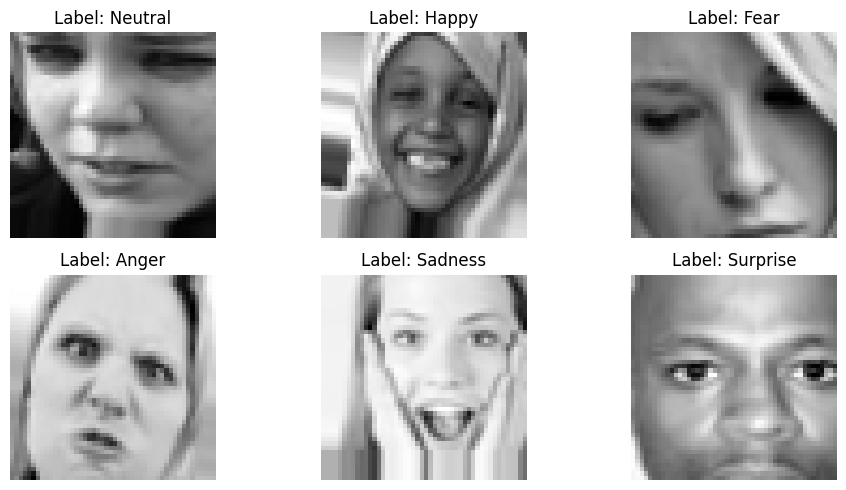

Shape of one batch (X): (64, 48, 48, 1)
Shape of one batch (y): (64, 7)


In [16]:
# To visualize one batch of augmented images (just for clarity)
x_batch, y_batch = next(train_generator)

# Show a few augmented images from the batch
plt.figure(figsize=(10, 5))
for i in range(6):  # Displaying 6 images
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i].reshape(48, 48), cmap='gray')
    plt.title(f"Label: {CLASS_LABELS[np.argmax(y_batch[i])]}")  # Display the label
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print the shape of one batch of data
print(f"Shape of one batch (X): {x_batch.shape}")  # Should be (64, 48, 48, 1)
print(f"Shape of one batch (y): {y_batch.shape}")  # Should be (64, 7)


-Conclusion :

Ces étapes de prétraitement garantissent que les données sont prêtes et optimisées pour l'entraînement du modèle CNN, améliorant ainsi la performance et la généralisation du modèle.

## 5. la création de modèle

Introduction:

Dans cette section, nous explorerons différentes approches pour améliorer la reconnaissance des émotions faciales. Nous commencerons par une architecture CNN simple  afin d'établir une base solide. Ensuite, nous ajusterons les hyperparamètres, comme le taux d'apprentissage et le nombre d'époques, et ajouterons des couches pour optimiser les performances du modèle . Nous utiliserons également le transfert d'apprentissage avec MobileNetV2 , un modèle pré-entraîné, pour tirer parti des connaissances acquises sur de grandes bases de données. Enfin, nous aborderons l'augmentation des données et l'équilibrage des classes  pour traiter les déséquilibres dans les données et améliorer la généralisation du modèle. Ces différentes stratégies seront comparées pour évaluer leur impact sur la performance du modèle.

### - Visualisation de l'image et comparaison des prédictions

Cette fonction affiche une image de test avec son étiquette réelle et les probabilités prédites pour chaque émotion sous forme de graphique à barres.

In [29]:
import matplotlib.pyplot as plt

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number, emotions):
    """
    Function to plot the image and compare the prediction results with the true label
    Args:
        test_image_array: Array of test images (e.g., x_test_reshape_bl)
        test_image_label: Actual true labels of the test images
        pred_test_labels: Predictions (probabilities) from the model for each image
        image_number: The index of the image to visualize
        emotions: A dictionary that maps label numbers to emotion names (e.g., {0: 'Angry', 1: 'Disgust', ...})
    """

    # Create a subplot with 1 row and 2 columns (for the image and the bar plot)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    # Plot the test image
    axs[0].imshow(test_image_array[image_number], cmap='gray')  # Use 'gray' for grayscale images
    axs[0].set_title(f"True: {emotions[test_image_label[image_number]]}")

    # Plot the predicted probabilities as a bar plot
    bar_labels = list(emotions.values())  # Get the emotion names for the x-axis
    axs[1].bar(bar_labels, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].set_ylabel("Probability")
    axs[1].set_xlabel("Emotion")
    axs[1].set_title("Predicted Probabilities")
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


### 5.1 Architecture CNN simple

Nous commencerons par une architecture de réseau de neurones convolutifs (CNN) simple, qui est couramment utilisée pour la reconnaissance d'images. Cette architecture de base nous servira de point de départ pour évaluer les performances de notre modèle.

#### a- Architecture de modèle CNN simple

In [18]:
def cnn_model_nn1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=((48,48,1))))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(7 , activation='softmax'))

    return model

#### b- Compilation du modèle

In [19]:
#opt = tf.keras.optimizers.Adam(0.001)
model_cnn1 = cnn_model_nn1()
model_cnn1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_cnn1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         221,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,679 (1.13 MB)

 Trainable params: 296,295 (1.13 MB)

 Non-trainable params: 384 (1.50 KB)

#### c- Callbacks d'entraînement pour l'optimisation du modèle : EarlyStopping et ModelCheckpoint

Cette fonction configure les callbacks EarlyStopping et ModelCheckpoint pour arrêter l'entraînement en cas de stagnation de la performance et sauvegarder les meilleurs poids du modèle pendant l'entraînement.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback: stops training when the validation accuracy stops improving
checkpointer_cnn1 = [
    EarlyStopping(
        monitor='val_accuracy',        # Monitor validation accuracy
        verbose=1,                      # Print message when early stopping is triggered
        restore_best_weights=True,     # Restore model to the best weights
        mode="max",                     # 'max' for accuracy, 'min' for loss
        patience=15                     # Stop if no improvement for 10 epochs
    ),

    # ModelCheckpoint callback: save the model weights when validation accuracy improves
    ModelCheckpoint(
        'best_cnn1_model.keras',      # File name to save best weights
        monitor="val_accuracy",         # Monitor validation accuracy
        verbose=1,                      # Print message when weights are saved
        save_best_only=True,            # Save only the best weights
        mode="max"                    # Save when accuracy improves (mode=max for accuracy)

    )
]

#### d- Entraînement du modèle CNN

In [21]:
# Train the model with the callback
import time
# Record the start time
start_time1 = time.time()

history_cnn1 = model_cnn1.fit(
    train_generator,
    batch_size=50,
    epochs=60,
    validation_data=val_generator,
    callbacks=[checkpointer_cnn1]
)


# Record the end time
end_time1 = time.time()

# Calculate the time taken in seconds
time_taken1 = end_time1 - start_time1
print(f"Training time: {time_taken1} seconds")

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2136 - loss: 1.9803
Epoch 1: val_accuracy improved from -inf to 0.23098, saving model to best_cnn1_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.2137 - loss: 1.9795 - val_accuracy: 0.2310 - val_loss: 1.8480
Epoch 2/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2517 - loss: 1.7881
Epoch 2: val_accuracy improved from 0.23098 to 0.30649, saving model to best_cnn1_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2517 - loss: 1.7880 - val_accuracy: 0.3065 - val_loss: 1.7249
Epoch 3/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2907 - loss: 1.7229
Epoch 3: val_accuracy improved from 0.30649 to 0.34773, saving model to best_cnn1_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.2907 - loss: 1.7229 - val_accuracy: 0.3477 - val_loss: 1.6503
Epoch 4/60
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3089 - loss: 1.6723
Epoch 4: val_accuracy did n

#### e- Évaluation du modèle

-Visualisation des courbes d'exactitude et de perte pendant l'entraînement et la validation du modèle

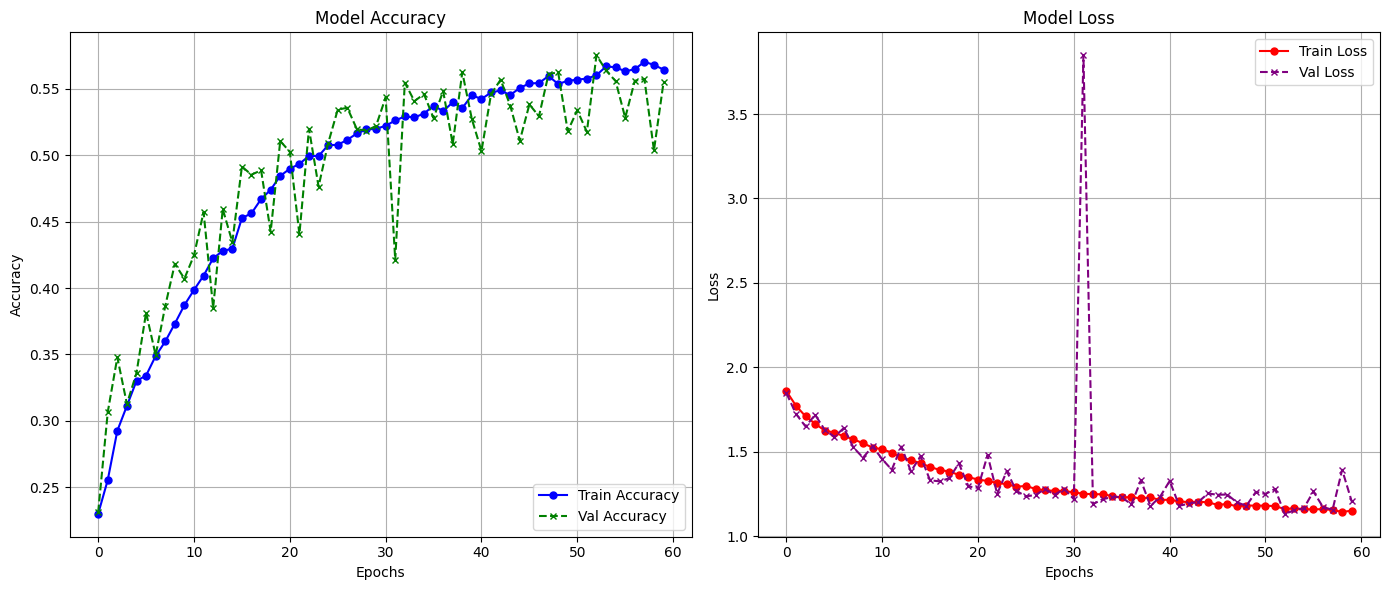

In [22]:
import matplotlib.pyplot as plt

# Create a figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy
ax1.plot(history_cnn1.history['accuracy'], label='Train Accuracy', color='b', linestyle='-', marker='o', markersize=5)
ax1.plot(history_cnn1.history['val_accuracy'], label='Val Accuracy', color='g', linestyle='--', marker='x', markersize=5)
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot the training and validation loss
ax2.plot(history_cnn1.history['loss'], label='Train Loss', color='r', linestyle='-', marker='o', markersize=5)
ax2.plot(history_cnn1.history['val_loss'], label='Val Loss', color='purple', linestyle='--', marker='x', markersize=5)
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


-Évaluation sur le jeu de test

In [23]:
test_loss_bl1, test_accuracy_bl1 = model_cnn1.evaluate(x_test_reshape, y_test)
print(f'Test Loss: {test_loss_bl1}')
print(f'Test Accuracy: {test_accuracy_bl1}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6005 - loss: 1.0722
Test Loss: 1.0686538219451904
Test Accuracy: 0.607968807220459


-Rapport de Classification et Matrice de Confusion

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

       Angry       0.52      0.52      0.52       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.45      0.26      0.33       528
       Happy       0.78      0.88      0.82       879
         Sad       0.46      0.51      0.48       594
    Surprise       0.73      0.78      0.75       416
     Neutral       0.57      0.62      0.60       626

    accuracy                           0.61      3589
   macro avg       0.50      0.51      0.50      3589
weighted avg       0.59      0.61      0.59      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


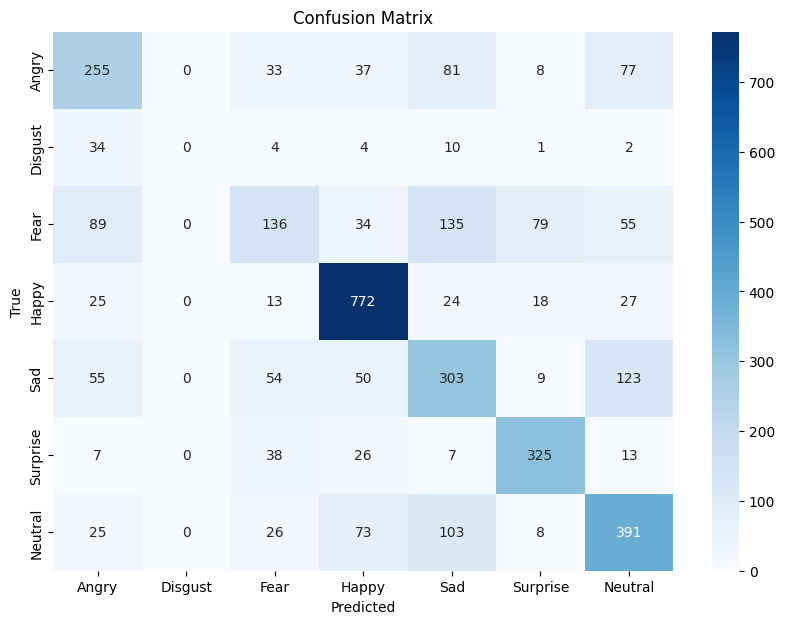

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Emotion mapping dictionary
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Predict on test data
y_pred_cnn1 = model_cnn1.predict(x_test_reshape)
y_pred_classes_cnn1 = y_pred_cnn1.argmax(axis=1)  # Get the class with max probability

# If your labels are one-hot encoded, convert them using argmax
y_true_cnn = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_true_cnn, y_pred_classes_cnn1, target_names=emotion_mapping.values()))

# Confusion matrix
cm_cnn1 = confusion_matrix(y_true_cnn, y_pred_classes_cnn1)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn1, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### f- Visualisation des Prédictions et Comparaison des Vrais Label

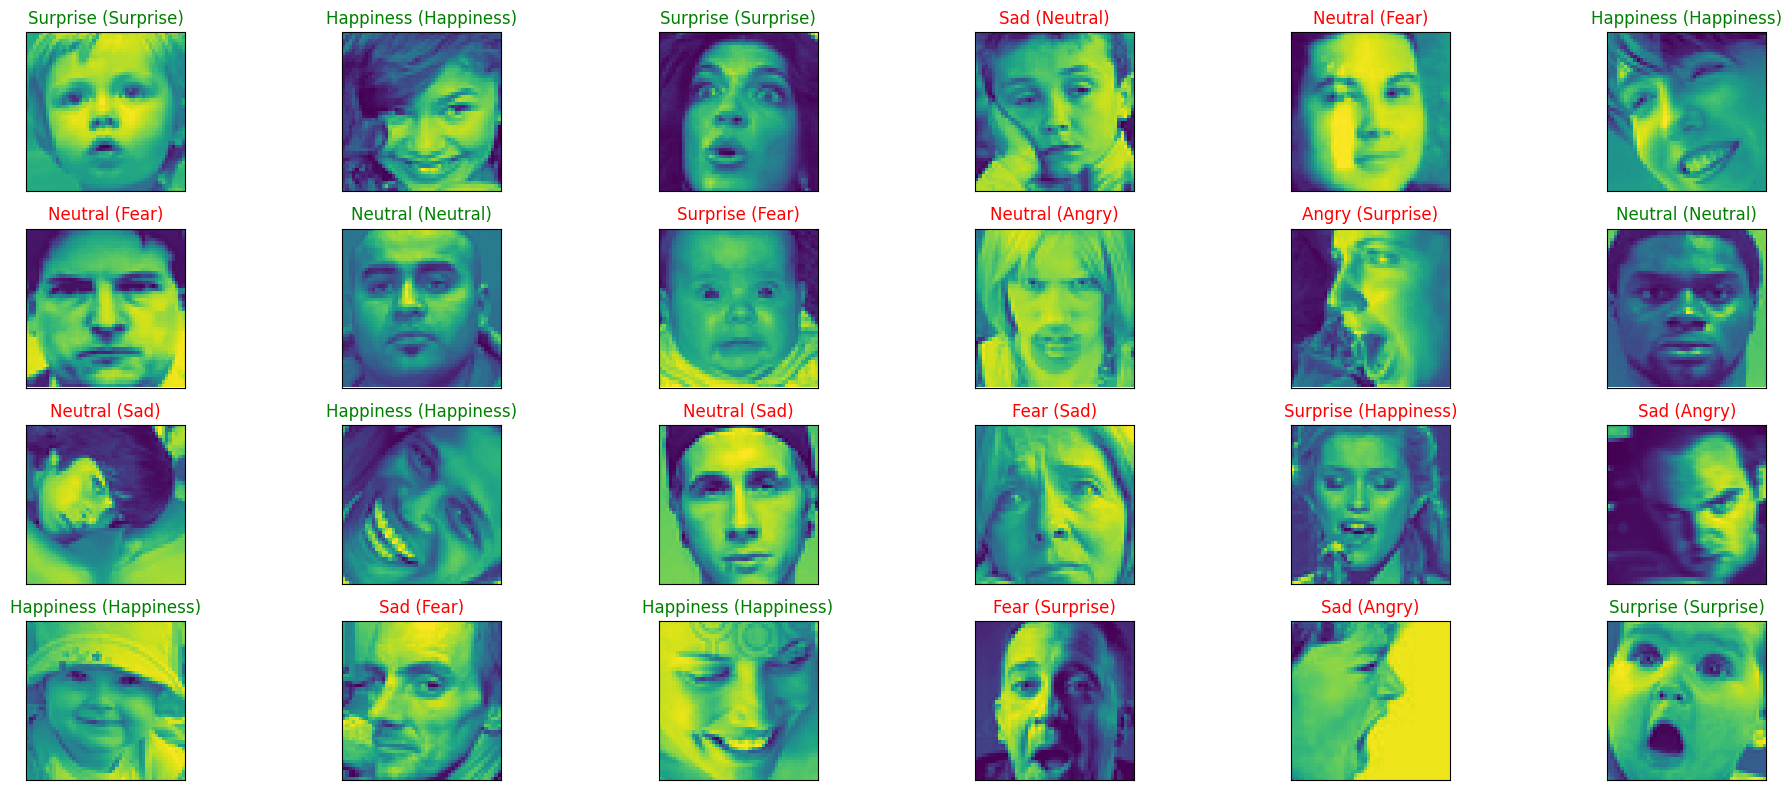

In [27]:
import matplotlib.pyplot as plt
import numpy as np

label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Create a figure with a size to display 24 images
figure1 = plt.figure(figsize=(20, 8))

# Ensure the random indices are within the correct bounds
num_samples = x_test_reshape.shape[0]

# Select 24 random indices from the test set, ensuring that the indices do not exceed the available samples
for i, index in enumerate(np.random.choice(num_samples, size=24, replace=False)):
    ax = figure1.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test_reshape[index]))  # Display the image

    # Get the predicted and true labels
    predict_index = label_dict[y_pred_cnn1[index].argmax()]  # Use .argmax() if y_pred_bl contains probabilities
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]

    # Set the title of each subplot, using green for correct predictions and red for incorrect
    ax.set_title("{} ({})".format(predict_index, true_index),
                 color="green" if predict_index == true_index else "red")

# Display the plot
plt.tight_layout()
plt.show()


#### g- Visualisation d'une Image avec Prédictions et Émotions

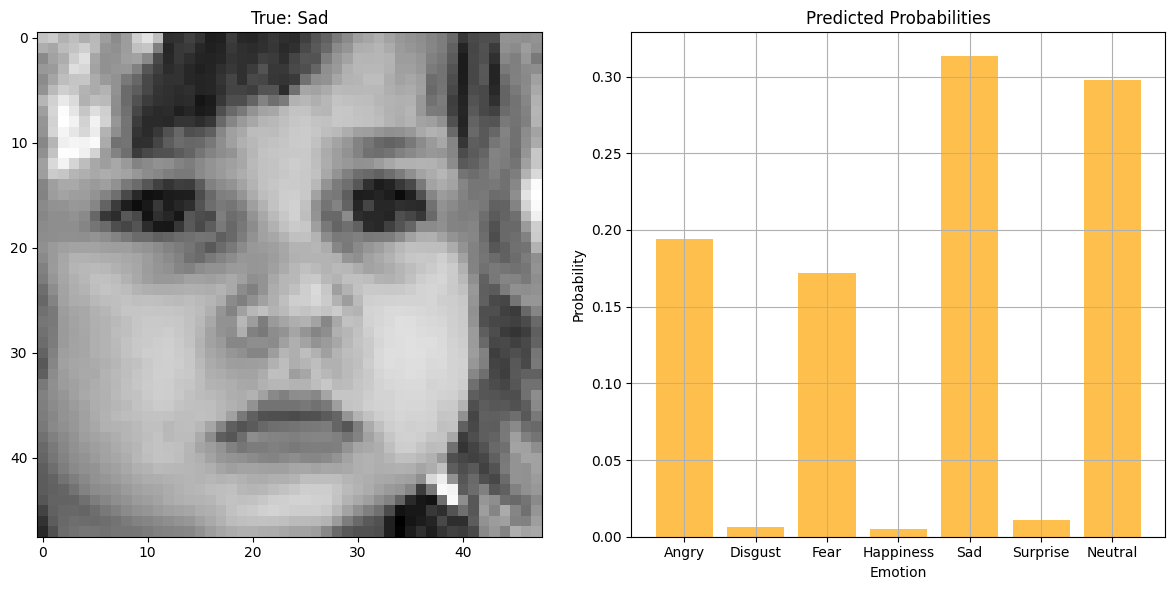

In [30]:
plot_image_and_emotion(x_test_reshape, y_test.argmax(axis=1), y_pred_cnn1, 123,emotions=label_dict)

#### k- Sauvegarde du Modèle CNN

In [32]:
model_cnn1.save('emotion_recognition_model_cnn1.keras')

#### l- Affichage des Meilleures Précisions d'Entraînement et de Validation

In [33]:
best_train_acc = max(history_cnn1.history['accuracy'])
best_val_acc = max(history_cnn1.history['val_accuracy'])

print(f"Best training accuracy: {best_train_acc}")
print(f"Best validation accuracy: {best_val_acc}")

Best training accuracy: 0.5704134702682495
Best validation accuracy: 0.5753691792488098


### 5.2 Changement du taux d'apprentissage, ajout de couches et ajustement du nombre d'époques

 Dans cette partie, nous ajusterons les hyperparamètres tels que le taux d'apprentissage et le nombre d'époques. Nous ajouterons également des couches pour améliorer la capacité du modèle à apprendre des caractéristiques complexes et éviter le surapprentissage.

#### a- Architecture de modèle

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

def cnn_model_nn2():
    model = Sequential()


    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten the features into a 1D vector
    model.add(Flatten())

    # First Dense Layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Second Dense Layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output Layer for 7-class classification
    model.add(Dense(7, activation='softmax'))

    return model


#### b- Compilation du modèle

In [35]:
#opt = tf.keras.optimizers.Adam(0.001)
model_cnn2 = cnn_model_nn2()
model_cnn2.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
model_cnn2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 128)           │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 343,271 (1.31 MB)

 Trainable params: 342,247 (1.31 MB)

 Non-trainable params: 1,024 (4.00 KB)

#### c- Callbacks d'entraînement pour l'optimisation du modèle

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback: stops training when the validation accuracy stops improving
checkpointer_cnn4 = [
    EarlyStopping(
        monitor='val_accuracy',        # Monitor validation accuracy
        verbose=1,                      # Print message when early stopping is triggered
        restore_best_weights=True,     # Restore model to the best weights
        mode="max",                     # 'max' for accuracy, 'min' for loss
        patience=12                     # Stop if no improvement for 10 epochs
    ),

    # ModelCheckpoint callback: save the best model weights when validation accuracy improves
    ModelCheckpoint(
        'best_model_cnn2.keras',    # Save best model in .keras format
        monitor="val_accuracy",         # Monitor validation accuracy
        verbose=1,                      # Print message when model is saved
        save_best_only=True,            # Save only the best model
        mode="max",                     # Save when accuracy improves (mode=max for accuracy)
        save_weights_only=False         # Save the entire model (architecture + weights)
    )
]


#### d- Entraînement du modèle CNN

In [37]:
# Train the model with the callback
import time
# Record the start time
start_time2 = time.time()

history_cnn2 = model_cnn2.fit(
    train_generator,
    batch_size=60,
    epochs=80,
    validation_data=val_generator,
    callbacks=checkpointer_cnn4
)


# Record the end time
end_time2 = time.time()

# Calculate the time taken in seconds
time_taken2 = end_time2 - start_time2
print(f"Training time: {time_taken2} seconds")

Epoch 1/80
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1496 - loss: 2.8247
Epoch 1: val_accuracy improved from -inf to 0.20535, saving model to best_model_cnn2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.1497 - loss: 2.8244 - val_accuracy: 0.2053 - val_loss: 2.1960
Epoch 2/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1639 - loss: 2.6898
Epoch 2: val_accuracy improved from 0.20535 to 0.21064, saving model to best_model_cnn2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.1639 - loss: 2.6898 - val_accuracy: 0.2106 - val_loss: 2.0226
Epoch 3/80
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1669 - loss: 2.6472
Epoch 3: val_accuracy improved from 0.21064 to 0.22485, saving model to best_model_cnn2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.1669 - loss: 2.6471 - val_accuracy: 0.2249 - val_loss: 1.9761
Epoch 4/80
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1689 - loss: 2.6124
Epoch 4: val_acc

#### e- Évaluation du modèle

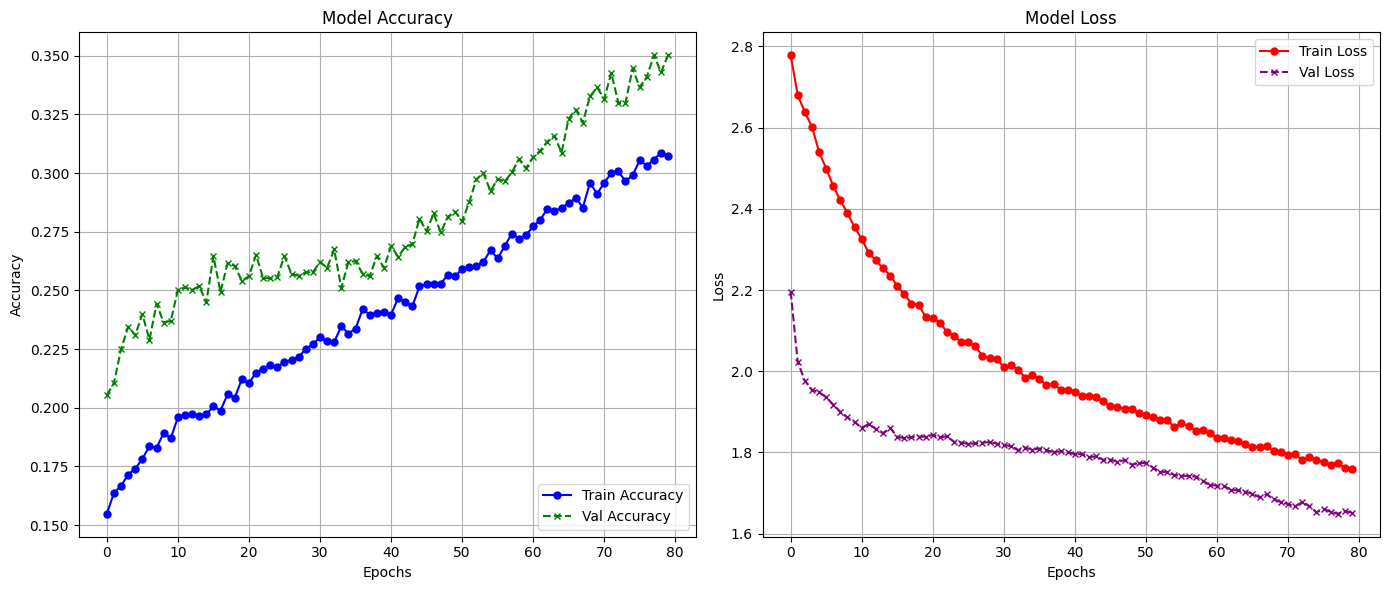

In [38]:
import matplotlib.pyplot as plt

# Create a figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy
ax1.plot(history_cnn2.history['accuracy'], label='Train Accuracy', color='b', linestyle='-', marker='o', markersize=5)
ax1.plot(history_cnn2.history['val_accuracy'], label='Val Accuracy', color='g', linestyle='--', marker='x', markersize=5)
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot the training and validation loss
ax2.plot(history_cnn2.history['loss'], label='Train Loss', color='r', linestyle='-', marker='o', markersize=5)
ax2.plot(history_cnn2.history['val_loss'], label='Val Loss', color='purple', linestyle='--', marker='x', markersize=5)
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [39]:
# Assuming you have test data (X_test, y_test)
test_loss_cnn2, test_accuracy_cnn2 = model_cnn2.evaluate(x_test_reshape, y_test)
print(f'Test Loss: {test_loss_cnn2}')
print(f'Test Accuracy: {test_accuracy_cnn2}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3775 - loss: 1.5820
Test Loss: 1.5932196378707886
Test Accuracy: 0.3708553910255432


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Angry       0.30      0.08      0.13       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.25      0.07      0.11       528
       Happy       0.40      0.82      0.53       879
         Sad       0.29      0.13      0.18       594
    Surprise       0.39      0.65      0.49       416
     Neutral       0.35      0.30      0.33       626

    accuracy                           0.37      3589
   macro avg       0.28      0.29      0.25      3589
weighted avg       0.33      0.37      0.31      3589



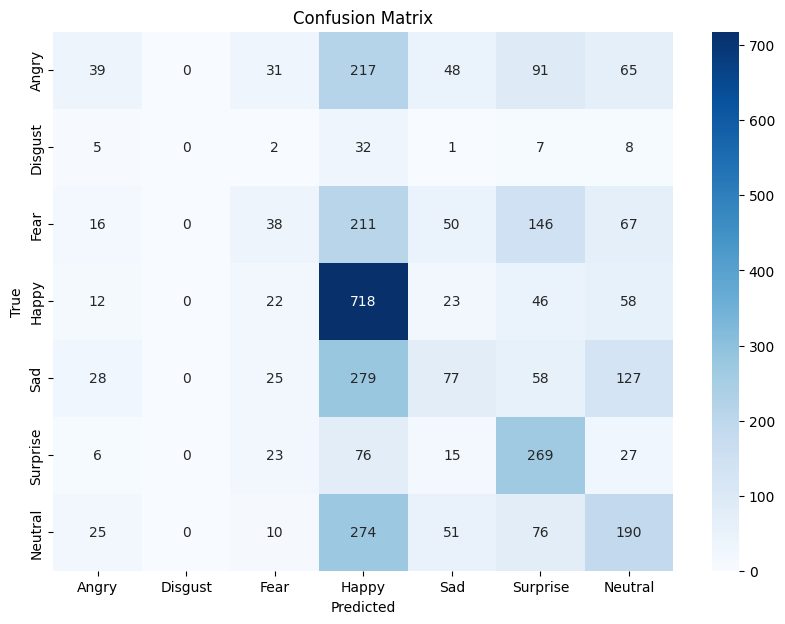

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Emotion mapping dictionary
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Predict on test data
y_pred_cnn2 = model_cnn2.predict(x_test_reshape)
y_pred_classes_cnn2 = y_pred_cnn2.argmax(axis=1)  # Get the class with max probability

# If your labels are one-hot encoded, convert them using argmax
y_true_cnn2 = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_true_cnn2, y_pred_classes_cnn2, target_names=emotion_mapping.values()))

# Confusion matrix
cm_cnn2 = confusion_matrix(y_true_cnn2, y_pred_classes_cnn2)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn2, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### f- Visualisation des Prédictions et Comparaison des Vrais Label

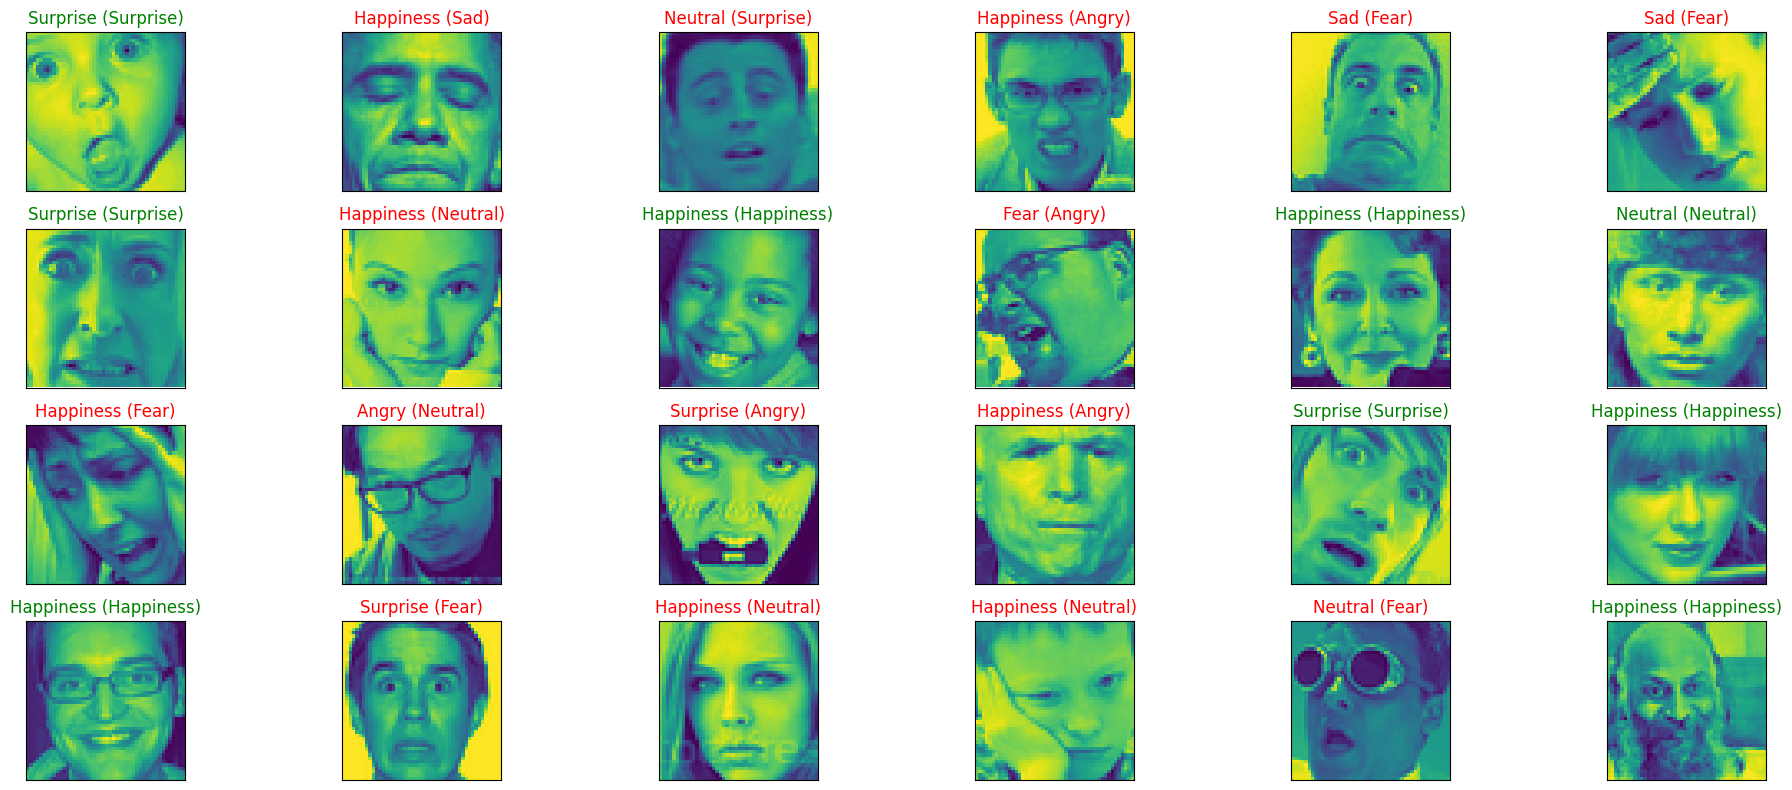

In [41]:
import matplotlib.pyplot as plt
import numpy as np

label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Create a figure with a size to display 24 images
figure_cnn2 = plt.figure(figsize=(20, 8))

# Ensure the random indices are within the correct bounds
num_samples_cnn2 = x_test_reshape.shape[0]

# Select 24 random indices from the test set, ensuring that the indices do not exceed the available samples
for i, index in enumerate(np.random.choice(num_samples_cnn2, size=24, replace=False)):
    ax = figure_cnn2.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test_reshape[index]))  # Display the image

    # Get the predicted and true labels
    predict_index_cnn2 = label_dict[y_pred_cnn2[index].argmax()]  # Use .argmax() if y_pred_bl contains probabilities
    true_index_cnn2 = label_dict[np.argmax(y_test, axis=1)[index]]

    # Set the title of each subplot, using green for correct predictions and red for incorrect
    ax.set_title("{} ({})".format(predict_index_cnn2, true_index_cnn2),
                 color="green" if predict_index_cnn2 == true_index_cnn2 else "red")

# Display the plot
plt.tight_layout()
plt.show()


#### g- Visualisation d'une Image avec Prédictions et Émotions

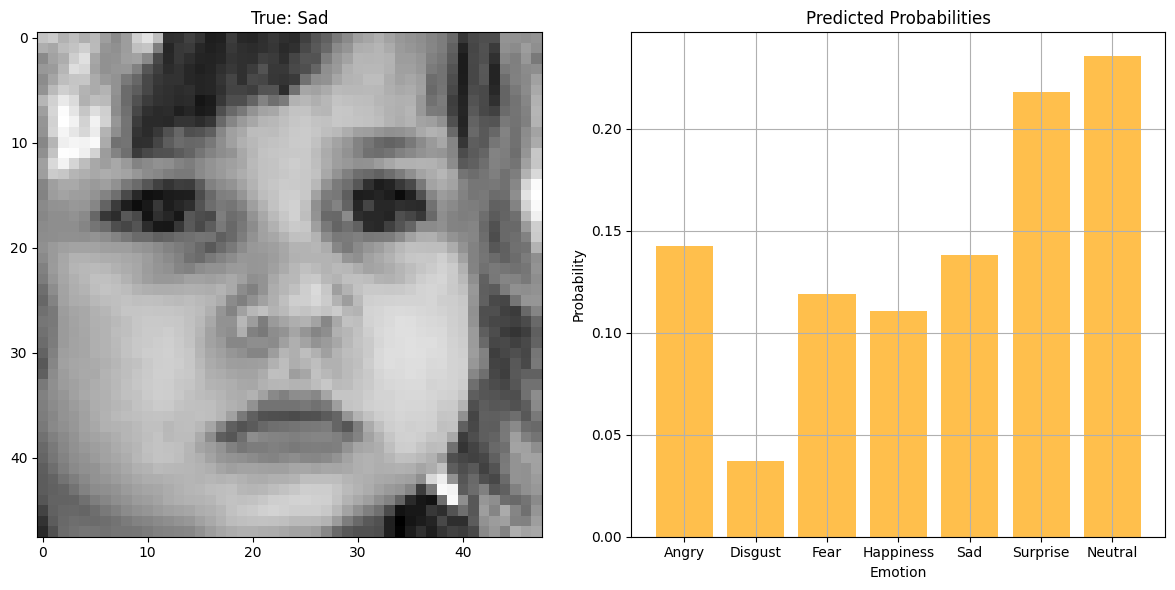

In [42]:
plot_image_and_emotion(x_test_reshape, y_test.argmax(axis=1), y_pred_cnn2, 123,emotions=label_dict)

####k- Sauvegarde du Modèle CNN

In [46]:
# Save the model to a file
model_cnn2.save('emotion_recognition_model_cnn2.keras')

#### l- Affichage des Meilleures Précisions d'Entraînement et de Validation

In [44]:
best_train_acc2 = max(history_cnn2.history['accuracy'])
best_val_acc2 = max(history_cnn2.history['val_accuracy'])

print(f"Best training accuracy: {best_train_acc2}")
print(f"Best validation accuracy: {best_val_acc2}")

Best training accuracy: 0.3087881803512573
Best validation accuracy: 0.35023683309555054


### 5.3  Transfert d'apprentissage avec MobileNetV2

Nous explorerons l'utilisation du transfert d'apprentissage avec MobileNetV2, un modèle pré-entraîné. Cela nous permettra de tirer parti des connaissances acquises par ce modèle sur de vastes ensembles de données et d'améliorer les performances de notre modèle pour la reconnaissance des émotions.

####  1: mporter les bibliothèques nécessaires

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### 2: Prétraitement des données

In [48]:
# Convert grayscale images to RGB
def preprocess_input_images(images):
    return np.repeat(images, 3, axis=-1)  # Convert (48, 48, 1) to (48, 48, 3)

# Preprocess the data
x_train_reshape_rgb = preprocess_input_images(x_train_reshape)
x_val_reshape_rgb = preprocess_input_images(x_val_reshape)
x_test_reshape_rgb = preprocess_input_images(x_test_reshape)

print("Reshaped arrays:")
print("X_train:", x_train_reshape_rgb.shape)
print("X_val:", x_val_reshape_rgb.shape)
print("X_test:", x_test_reshape_rgb.shape)


Reshaped arrays:
X_train: (28709, 48, 48, 3)
X_val: (3589, 48, 48, 3)
X_test: (3589, 48, 48, 3)


#### 3: Augmentation des données

In [49]:
# Initialize ImageDataGenerator with augmentations for training
datagen_train_cnn3 = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    zoom_range=0.2
)

# Initialize ImageDataGenerator for validation (no augmentation)
datagen_val_cnn3 = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

In [50]:
# Fit the datagen_train to the training data (for statistics)
datagen_train_cnn3.fit(x_train_reshape_rgb)

In [51]:
train_generator_cnn3 = datagen_train_cnn3.flow(x_train_reshape_rgb, y_train, batch_size=64)
val_generator_cnn3 = datagen_val_cnn3.flow(x_val_reshape_rgb, y_val, batch_size=64)

####  4: Construction du modèle avec MobileNetV2

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Rescaling, GlobalAveragePooling2D

def cnn_model_nn3(input_shape=(48, 48, 1), num_classes=7):
    # Define the Sequential model
    model = models.Sequential()

    # Input layer (implicitly created with input_shape in the first Resizing layer)
    model.add(layers.Resizing(96, 96, input_shape=input_shape))  # Resize input to 96x96

    # Preprocessing stage
    model.add(Rescaling(scale=1/127.0, offset=-1))  # Rescaling to normalize the pixel values
    model.add(layers.RandomRotation(factor=0.2, seed=100))  # Random rotation for augmentation
    model.add(layers.RandomFlip(mode="horizontal", seed=100))  # Random horizontal flip for augmentation
    model.add(layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=100))  # Random zoom
    model.add(layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest", seed=100))  # Random translation (shift)

    # Load MobileNetV2 model, pre-trained on ImageNet, without the top layer
    base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

    # Freeze all layers initially to prevent training on the base model during the first phase
    base_model.trainable = False  # Freeze the base model initially
    model.add(base_model)

    # Add additional convolutional layers to extract more features (without MaxPooling2D here)
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Global Average Pooling to reduce dimensionality
    model.add(GlobalAveragePooling2D())

    # Classification stage
    model.add(Dense(512, activation='relu'))  # Larger fully connected layer to increase capacity
    model.add(BatchNormalization())  # BatchNormalization for better convergence
    model.add(Dropout(0.5))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [78]:
#opt = tf.keras.optimizers.Adam(0.001)
model_cnn33 = cnn_model_nn3()
model_cnn33.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
model_cnn33.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)                │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_5 (RandomRotation)   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_5 (RandomFlip)           │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_2                 │ (None, 96, 96, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 3, 128)           │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,166,599 (15.89 MB)

 Trainable params: 1,906,823 (7.27 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

####  5: Configuration des callbacks

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback: stops training when the validation accuracy stops improving
checkpointer_cnn3 = [
    EarlyStopping(
        monitor='val_accuracy',        # Monitor validation accuracy
        verbose=1,                      # Print message when early stopping is triggered
        restore_best_weights=True,     # Restore model to the best weights
        mode="max",                     # 'max' for accuracy, 'min' for loss
        patience=10                     # Stop if no improvement for 10 epochs
    ),

    # ModelCheckpoint callback: save the best model weights when validation accuracy improves
    ModelCheckpoint(
        'best_model_mobileV2.keras',    # Save best model in .keras format
        monitor="val_accuracy",         # Monitor validation accuracy
        verbose=1,                      # Print message when model is saved
        save_best_only=True,            # Save only the best model
        mode="max",                     # Save when accuracy improves (mode=max for accuracy)
        save_weights_only=False         # Save the entire model (architecture + weights)
    )
]


#### 6: Entraînement du modèle CNN

In [80]:
historycnn3 = model_cnn33.fit(
    train_generator_cnn3,
    validation_data=val_generator_cnn3,
    batch_size=60,
    epochs=80,
    callbacks=checkpointer_cnn3
)

Epoch 1/80
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1570 - loss: 2.0176
Epoch 1: val_accuracy improved from -inf to 0.24993, saving model to best_model_mobileV2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.1571 - loss: 2.0174 - val_accuracy: 0.2499 - val_loss: 1.9233
Epoch 2/80
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1979 - loss: 1.9264
Epoch 2: val_accuracy did not improve from 0.24993
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.1979 - loss: 1.9264 - val_accuracy: 0.2034 - val_loss: 2.5498
Epoch 3/80
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2323 - loss: 1.8963
Epoch 3: val_accuracy did not improve from 0.24993
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.2323 - loss: 1.8963 - val_accuracy: 0.1301 - val_loss: 2.6499
Epoch 4/80
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2351 - loss: 1.8800
Epoch 4: val_accuracy did not improve from 0.24993
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - a

#### 7:  Évaluation du modèle

In [82]:
test_loss_cnn3, test_accuracy_cnn3 = model_cnn33.evaluate(x_test_reshape_rgb, y_test)
print(f"Test Loss: {test_loss_cnn3}")
print(f"Test Accuracy: {test_accuracy_cnn3}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2457 - loss: 1.9192
Test Loss: 1.9155681133270264
Test Accuracy: 0.24519364535808563


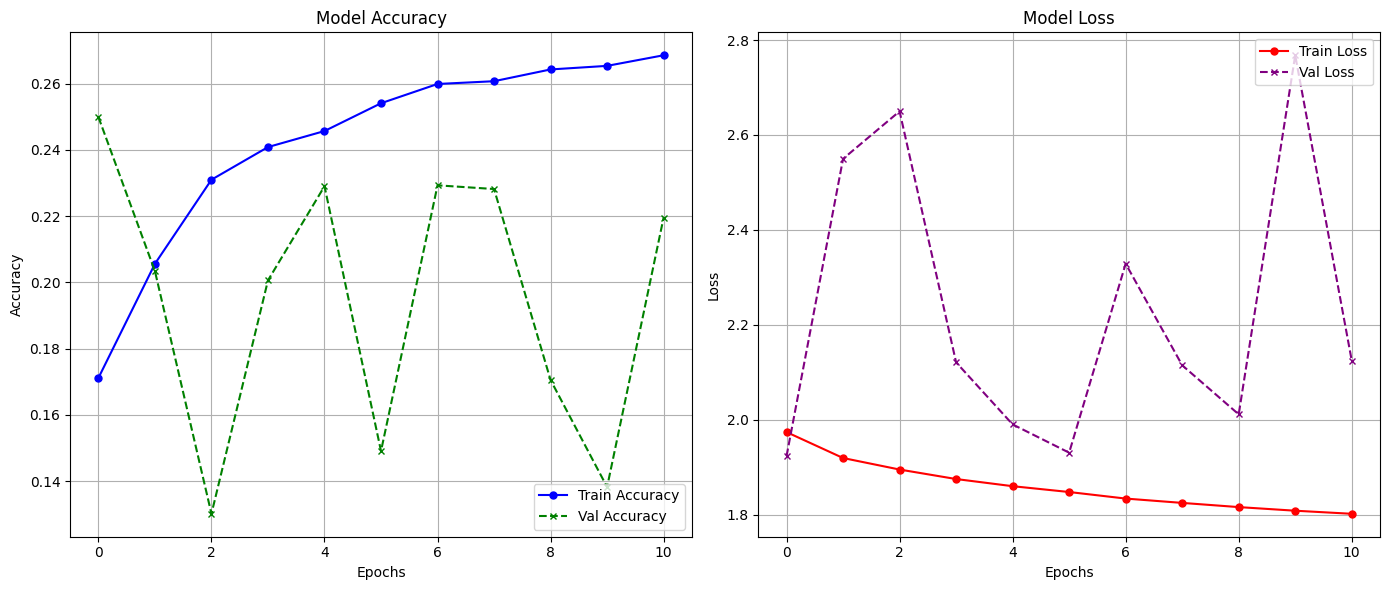

In [84]:
import matplotlib.pyplot as plt

# Create a figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy
ax1.plot(historycnn3.history['accuracy'], label='Train Accuracy', color='b', linestyle='-', marker='o', markersize=5)
ax1.plot(historycnn3.history['val_accuracy'], label='Val Accuracy', color='g', linestyle='--', marker='x', markersize=5)
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot the training and validation loss
ax2.plot(historycnn3.history['loss'], label='Train Loss', color='r', linestyle='-', marker='o', markersize=5)
ax2.plot(historycnn3.history['val_loss'], label='Val Loss', color='purple', linestyle='--', marker='x', markersize=5)
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Angry       0.36      0.01      0.02       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.00      0.00      0.00       528
       Happy       0.24      1.00      0.39       879
         Sad       0.00      0.00      0.00       594
    Surprise       0.00      0.00      0.00       416
     Neutral       0.00      0.00      0.00       626

    accuracy                           0.25      3589
   macro avg       0.09      0.14      0.06      3589
weighted avg       0.11      0.25      0.10      3589



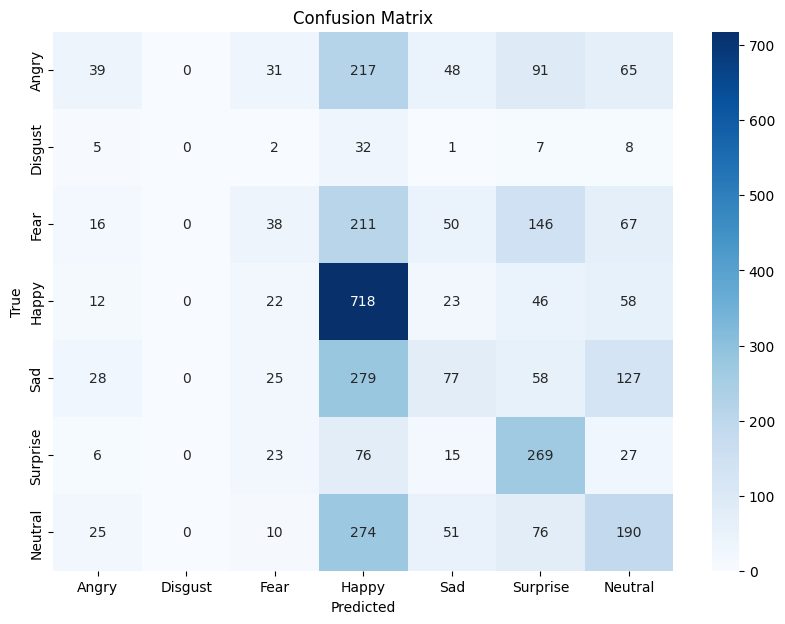

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Emotion mapping dictionary
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Predict on test data
y_pred_cnn3 = model_cnn33.predict(x_test_reshape_rgb)
y_pred_classes_cnn3 = y_pred_cnn3.argmax(axis=1)  # Get the class with max probability

# If your labels are one-hot encoded, convert them using argmax
y_true_cnn3 = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_true_cnn3, y_pred_classes_cnn3, target_names=emotion_mapping.values()))

# Confusion matrix
cm_cnn3 = confusion_matrix(y_true_cnn3, y_pred_classes_cnn3)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn2, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### 5.4 Architecture avec augmentation des données et équilibrage des classes

Enfin, nous aborderons l'augmentation des données et l'équilibrage des classes pour traiter les déséquilibres dans les données. Cela permettra de générer davantage d'exemples pour les classes sous-représentées et d'améliorer la généralisation du modèle.

#### 1: Augmentation des données et équilibrage des classes

Cette section décrit l'utilisation de l'augmentation des données et de l'équilibrage des classes pour améliorer la performance du modèle. L'oversampling est appliqué aux classes minoritaires en générant de nouvelles images via des techniques comme la rotation, les translations et le zoom, afin d'augmenter leur nombre jusqu'à un seuil cible de 2500 échantillons. En revanche, l'undersampling est utilisé pour réduire le nombre d'échantillons des classes majoritaires en sélectionnant un sous-ensemble aléatoire d'images. Le tout est ensuite combiné et mélangé pour garantir un ensemble de données équilibré et aléatoire, ce qui permet de former un modèle plus robuste et moins biaisé.

In [ ]:
data_bl=pd.read_csv('data.csv')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Target number of samples per class
target_samples = 2500

balanced_data = []

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Separate the dataset into groups by emotion
groups = data_bl.groupby('emotion')

# Loop through each emotion group
for emotion, group in groups:
    num_samples = len(group)
    print(f'Class {emotion} has {num_samples} samples')

    if num_samples < target_samples:
        # Oversample by generating augmented data
        minority_class = group.copy()

        # Prepare minority class images
        X_minority = np.stack(minority_class['pixels'].apply(lambda x: np.array(x.split(), dtype='float32')).values)
        X_minority = X_minority.reshape(-1, 48, 48, 1)  # Reshape to (num_samples, height, width, channels)

        # Calculate how many new samples are needed
        num_needed = target_samples - num_samples
        augmented_images = []

        # Generate the required number of samples
        num_generated = 0
        while num_generated < num_needed:
            # Generate a small batch of augmented images
            for batch in datagen.flow(X_minority, batch_size=32):  # You can still use a batch size of 32
                augmented_images.append(batch)
                num_generated += batch.shape[0]  # Number of generated images in this batch
                if num_generated >= num_needed:
                    break

        # Concatenate the augmented images and trim to the exact number needed
        augmented_images = np.concatenate(augmented_images, axis=0)[:num_needed]

        # Create new pixels from augmented images
        new_pixels = [' '.join(map(str, img.flatten().astype(int))) for img in augmented_images]
        new_rows = pd.DataFrame({'emotion': [emotion] * len(new_pixels), 'pixels': new_pixels, 'Usage': [group['Usage'].iloc[0]] * len(new_pixels)})

        # Append original and new rows
        balanced_data.append(pd.concat([minority_class, new_rows]))

    elif num_samples > target_samples:
        # Undersample if the class has more than target_samples
        # Sample randomly to reduce the size to target_samples
        undersampled_class = group.sample(target_samples, random_state=42)
        balanced_data.append(undersampled_class)

    else:
        # Class already has the target number of samples
        balanced_data.append(group)

# Combine all classes into a balanced dataset
balanced_dataset = pd.concat(balanced_data)

# Shuffle the dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the class distribution of the new dataset
print("New balanced dataset shape:", balanced_dataset.shape)
print(balanced_dataset['emotion'].value_counts())


Class 0 has 4953 samples
Class 1 has 547 samples
Class 2 has 5121 samples
Class 3 has 8989 samples
Class 4 has 6077 samples
Class 5 has 4002 samples
Class 6 has 6198 samples
New balanced dataset shape: (17500, 3)
emotion
0    2500
3    2500
1    2500
4    2500
5    2500
2    2500
6    2500
Name: count, dtype: int64


###### Visualisation des images originales et augmentées

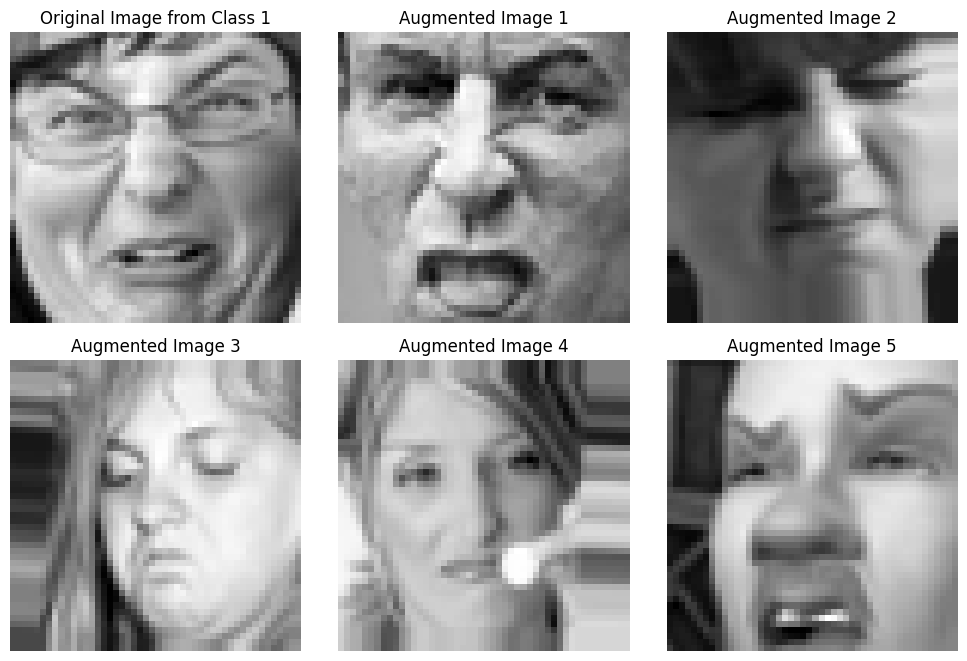

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to convert 'pixels' string to numpy array
def string_to_image(pixel_string):
    pixel_values = np.array(pixel_string.split(), dtype='float32')
    return pixel_values.reshape(48, 48)  # Reshape to 48x48 image

# Extract the rows of the balanced dataset where new (augmented) images were added
augmented_images_data = balanced_dataset[balanced_dataset['Usage'] == 'Training']  # Assuming 'Usage' column contains 'Training' for new samples

# Select a few random augmented images (for example, 5 from class 1)
class_1_augmented_images = augmented_images_data[augmented_images_data['emotion'] == 1]

# Plot the original and some of the augmented images
plt.figure(figsize=(10, 10))

# Plot the original image from class 1 (for comparison)
original_image = data_bl[data_bl['emotion'] == 1].iloc[0]['pixels']
original_image = string_to_image(original_image)

plt.subplot(3, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image from Class 1')
plt.axis('off')

# Plot some augmented images from the new dataset
for i in range(1, 6):  # Show 5 augmented images
    augmented_image = class_1_augmented_images.iloc[i]['pixels']
    augmented_image = string_to_image(augmented_image)

    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f'Augmented Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### 2: Visualisation des données

##### a. Visualisation du Nombre d'Images par Émotion et Type d'Usage

Cette section crée un graphique empilé à l'aide de Plotly pour visualiser la distribution des différentes émotions dans les catégories "Training" et "Testing" du jeu de données après l'augmentation. Chaque barre du graphique représente le nombre d'images de chaque émotion pour un type d'usage donné, permettant ainsi de voir l'impact de l'augmentation des données sur l'équilibrage des classes entre l'entraînement et le test.

In [ ]:
import pandas as pd
import plotly.express as px

# Load the augmented data (assuming you've already combined original and augmented data into balanced_dataset)
data_plot_bl = balanced_dataset.copy()  # Make a deep copy of the original balanced_dataset


# Define the class labels and create a mapping
CLASS_LABELS2 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
emotion_map2 = {i: label for i, label in enumerate(CLASS_LABELS2)}

# Map numeric emotion values to class labels
data_plot_bl['emotion_labels'] = data_plot_bl['emotion'].map(emotion_map2)

# Group by 'Usage' and count occurrences of each 'emotion_labels' within each usage category
usage_emotion_counts = data_plot_bl.groupby(['Usage', 'emotion_labels']).size().unstack(fill_value=0)

# Reset the index to have 'Usage' as a column
usage_emotion_counts = usage_emotion_counts.reset_index()

# Plot the result using Plotly for better visualization
fig2 = px.bar(
    usage_emotion_counts,
    x='Usage',
    y=usage_emotion_counts.columns[1:],  # All columns except the first one (Usage)
    title="Number of Each Emotion Label in Different Usage Categories (After Augmentation)",
    labels={'value': 'Number of Images', 'emotion_labels': 'Emotion'},
    barmode='stack'
)

# Update layout for better readability
fig2.update_layout(
    xaxis_title="Usage Type",
    yaxis_title="Number of Instances",
    legend_title="Emotion Label"
)

# Show the plot
fig2.show()


##### b. Visualisation de la Répartition des Émotions (Diagramme en Secteurs)

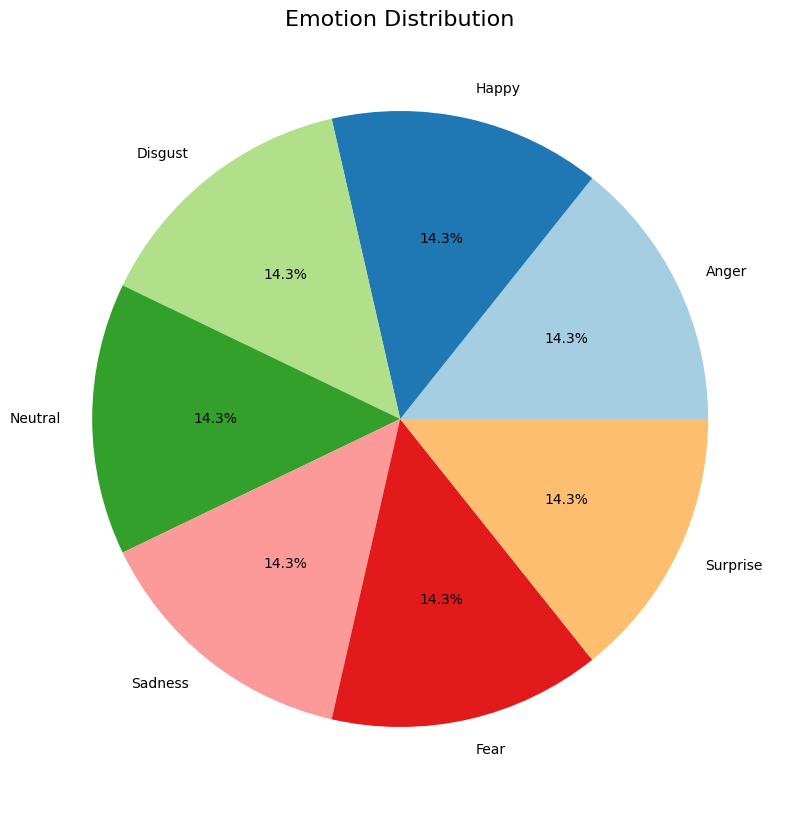

In [ ]:
data_pl2 =  balanced_dataset.copy()
# Define the CLASS_LABELS
CLASS_LABELS2 = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Create a dictionary to map numerical values to emotion labels
emotion_map2 = {i: label for i, label in enumerate(CLASS_LABELS2)}

# If 'data['emotion']' contains numerical values (e.g., 0, 1, 2, 3, ...), we can map them to the labels
data_pl2['emotion'] = data_pl2['emotion'].map(emotion_map2)

# Now, plot the pie chart
country_counts2 = data_pl2['emotion'].value_counts()

# Plot
plt.figure(figsize=(12, 10))
plt.pie(country_counts2, labels=country_counts2.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts2))))
plt.title('Emotion Distribution', fontsize=16)
plt.show()


##### c. Visualisation des Images d'Émotions dans le Jeu de Données Équilibré

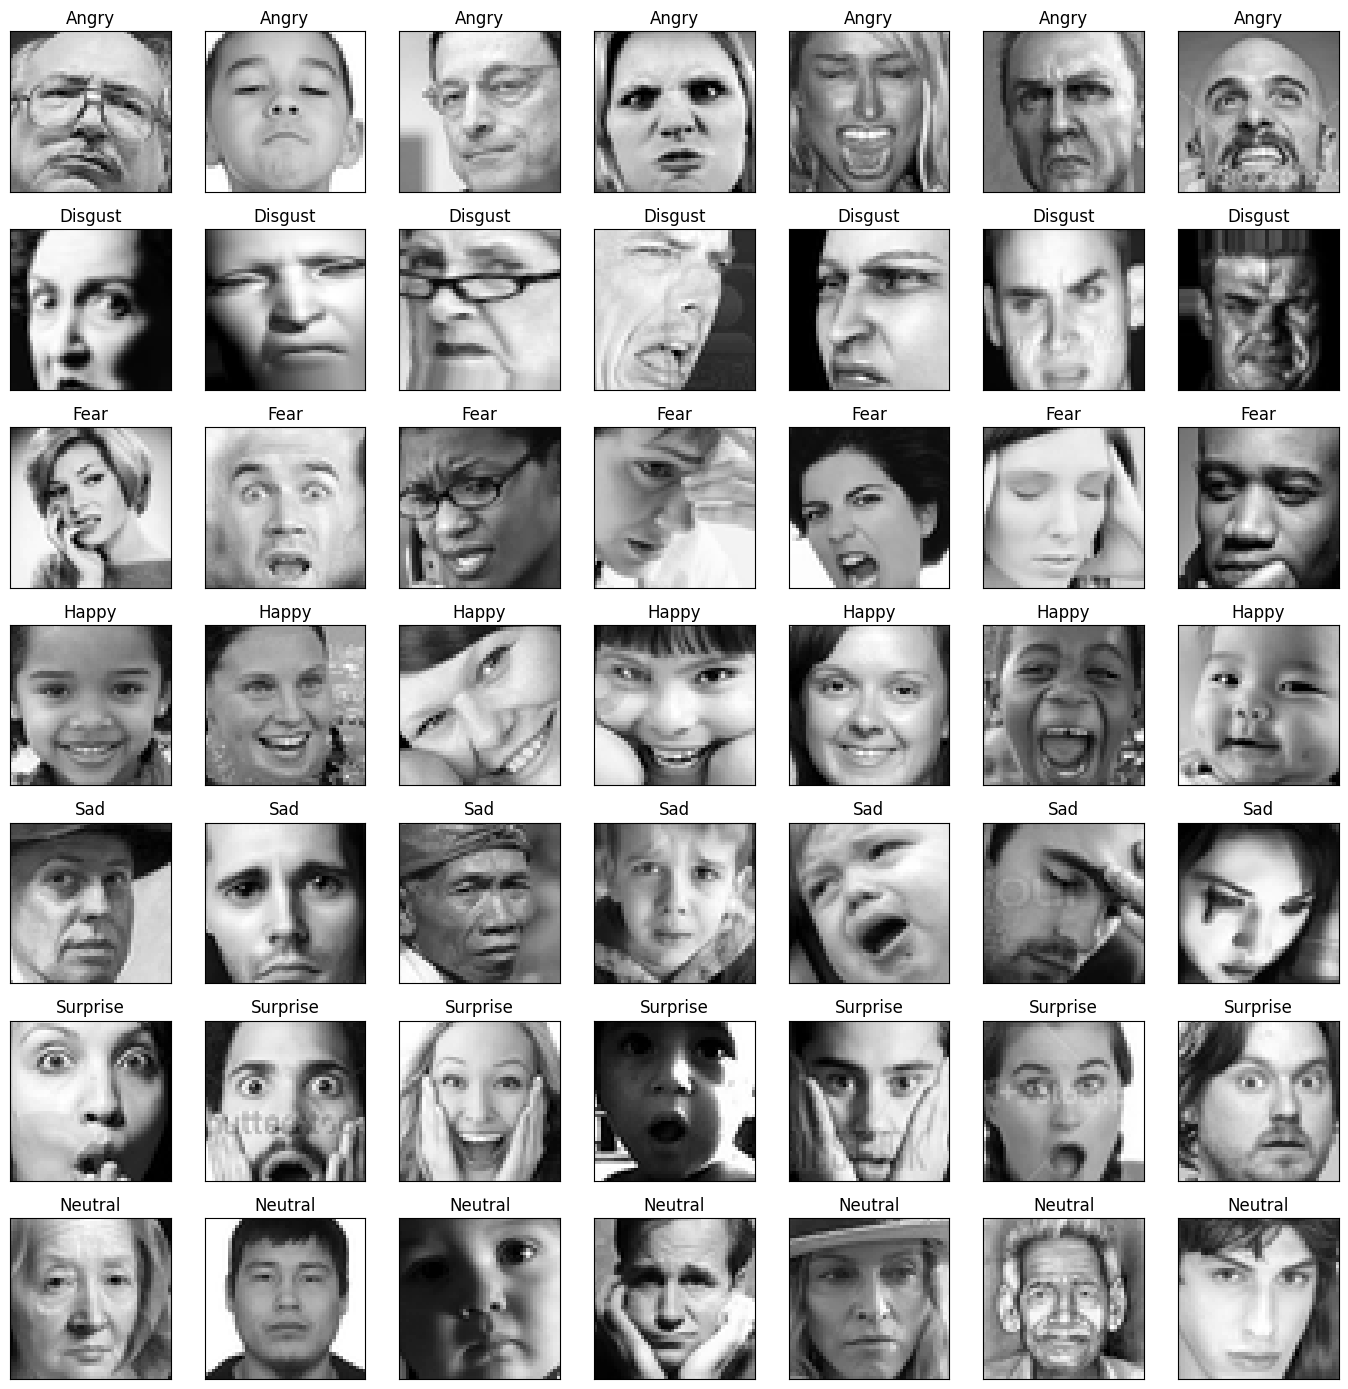

In [ ]:
from matplotlib import pyplot
import numpy as np

# Assuming balanced_dataset is your balanced DataFrame and emotion_mapping is defined
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

fig = pyplot.figure(1, (14, 14))

# Initialize `k` for indexing through images
k = 0

# Loop through each unique emotion in the balanced dataset
for label in sorted(balanced_dataset.emotion.unique()):
    emotion_data = balanced_dataset[balanced_dataset.emotion == label]

    # Reset `k` for each emotion class
    for j in range(min(7, len(emotion_data))):  # Limit to 7 images per emotion
        px = emotion_data.pixels.iloc[k]

        # Split the pixel data and reshape into a 48x48 image
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        # Increment `k` for each image processed
        k += 1

        # Plot each image
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        ax.set_title(emotion_mapping[label])  # Set title using emotion_mapping

    # Adjust layout to prevent overlapping
    pyplot.tight_layout()

# Show the plot
pyplot.show()


##### d. Distribution des Labels dans la Colonne 'Usage'

In [ ]:
import pandas as pd
import plotly.express as px


data_plot_bl5 = balanced_dataset.copy()
# Count the number of occurrences for each label in the 'Usage' column
usage_counts = data_plot_bl5['Usage'].value_counts().reset_index()
usage_counts.columns = ['Usage', 'Count']

# Create a bar chart using Plotly
fig = px.bar(usage_counts, x='Usage', y='Count', title="Distribution of Labels in Usage Column", color='Usage')

# Update axes titles and layout
fig.update_xaxes(title="Usage Type")
fig.update_yaxes(title="Number of Instances")
fig.update_layout(showlegend=False)

# Show the plot
fig.show()


##### e. Répartition des Émotions à Travers les Différents Types d'Usage

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming balanced_dataset is already defined and available
data_plot5 = balanced_dataset.copy()

# Grouping by 'Usage' and 'emotion' and counting occurrences
usage_emotion_counts = data_plot5.groupby(['Usage', 'emotion']).size().reset_index(name='count')

# Mapping emotion indices to emotion names and emojis
CLASS_LABELS = ['Anger 😡', 'Disgust 🤢', 'Fear 😨', 'Happy 😊', 'Neutral 😐', 'Sadness 😢', 'Surprise 😲']

# Ensure that 'emotion' is integer-based, so it can be used as an index
usage_emotion_counts['emotion'] = usage_emotion_counts['emotion'].astype(int)

# Map the integer emotion values to emotion labels
usage_emotion_counts['emotion_label'] = usage_emotion_counts['emotion'].map(lambda x: CLASS_LABELS[x])

# Plot the data using Plotly
fig3 = px.bar(usage_emotion_counts,
             x='emotion_label', y='count',
             color='Usage',
             title='Emotion Distribution Across Different Usage Types',
             labels={'emotion_label': 'Emotion', 'count': 'Number of Images', 'Usage': 'Usage Type'},
             barmode='stack')

# Customize layout
fig3.update_layout(
    xaxis_title="Emotion",
    yaxis_title="Number of Images",
    showlegend=True,
    title={'text': 'Emotion Distribution in Training, PublicTest, and PrivateTest', 'x': 0.5, 'xanchor': 'center'}
)

# Show the plot
fig3.show()


#### 3: Prétraitement des données

##### a. Diviser les données en fonction de la colonne d'utilisation

In [ ]:
# Split the dataset into training, validation, and testing based on the 'Usage' column
train_balanced_dataset = balanced_dataset[balanced_dataset['Usage'] == 'Training']
val_balanced_dataset = balanced_dataset[balanced_dataset['Usage'] == 'PublicTest']  # Or 'PrivateTest' based on your need
test_balanced_dataset = balanced_dataset[balanced_dataset['Usage'] == 'PrivateTest']  # If you have a separate validation set

# Check the split
print(f"Training balanced_dataset shape: {train_balanced_dataset.shape}")
print(f"Testing balanced_dataset shape: {test_balanced_dataset.shape}")
print(f"Validation balanced_dataset shape: {val_balanced_dataset.shape}")

Training balanced_dataset shape: (14422, 3)
Testing balanced_dataset shape: (1544, 3)
Validation balanced_dataset shape: (1534, 3)


##### b. Convertir les pixels d'image en tableaux NumPy

In [ ]:
# Convert the 'pixels' column into NumPy arrays
def convert_pixels(dataset):
    return np.array(list(map(str.split, dataset['pixels'])), dtype=np.float32)

train_data_arr_balanced = convert_pixels(train_balanced_dataset)
val_data_arr_balanced = convert_pixels(val_balanced_dataset)
test_data_arr_balanced = convert_pixels(test_balanced_dataset)

print("Shape of raw pixel arrays:")
print("X_train:",train_data_arr_balanced.shape)
print("X_val:", val_data_arr_balanced.shape)
print("X_test:", test_data_arr_balanced.shape)

Shape of raw pixel arrays:
X_train: (14422, 2304)
X_val: (1534, 2304)
X_test: (1544, 2304)


##### c. Traiter les étiquettes

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert emotion labels to one-hot encoding
y_train_balanced = to_categorical(train_balanced_dataset['emotion'], num_classes=7)
y_val_balanced = to_categorical(val_balanced_dataset['emotion'], num_classes=7)
y_test_balanced = to_categorical(test_balanced_dataset['emotion'], num_classes=7)

print("One-hot encoded labels:")
print("y_train:", y_train_balanced.shape)
print("y_val:", y_val_balanced.shape)
print("y_test:", y_test_balanced.shape)

One-hot encoded labels:
y_train: (14422, 7)
y_val: (1534, 7)
y_test: (1544, 7)


##### d. Normalisation des valeurs des pixels

In [ ]:
# Check the range of pixel values  normalization
print(f"Pixel value range  normalization:")
print(f"Train data - min: {train_data_arr_balanced.min()}, max: {train_data_arr_balanced.max()}")
print(f"Validation data - min: {val_data_arr_balanced.min()}, max: {val_data_arr_balanced.max()}")
print(f"Test data - min: {test_data_arr_balanced.min()}, max: {test_data_arr_balanced.max()}")

Pixel value range  normalization:
Train data - min: 0.0, max: 255.0
Validation data - min: 0.0, max: 255.0
Test data - min: 0.0, max: 255.0


In [ ]:
# Normalize pixel values to the range 0-1
train_data_arr_balanced /= 255.0
val_data_arr_balanced /= 255.0
test_data_arr_balanced /= 255.0

# Check the range of pixel values after normalization
print(f"Pixel value range after normalization:")
print(f"Train data - min: {train_data_arr_balanced.min()}, max: {train_data_arr_balanced.max()}")
print(f"Validation data - min: {val_data_arr_balanced.min()}, max: {val_data_arr_balanced.max()}")
print(f"Test data - min: {test_data_arr_balanced.min()}, max: {test_data_arr_balanced.max()}")

Pixel value range after normalization:
Train data - min: 0.0, max: 1.0
Validation data - min: 0.0, max: 1.0
Test data - min: 0.0, max: 1.0


##### e. Redimensionnement pour l'entrée du CNN

In [ ]:
# Reshape the arrays to (samples, 48, 48, 1)
x_train_reshape_bl = train_data_arr_balanced.reshape(-1, 48, 48, 1)
x_val_reshape_bl = val_data_arr_balanced.reshape(-1, 48, 48, 1)
x_test_reshape_bl = test_data_arr_balanced.reshape(-1, 48, 48, 1)

print("Reshaped arrays:")
print("X_train:", x_train_reshape_bl.shape)
print("X_val:", x_val_reshape_bl.shape)
print("X_test:", x_test_reshape_bl.shape)

Reshaped arrays:
X_train: (14422, 48, 48, 1)
X_val: (1534, 48, 48, 1)
X_test: (1544, 48, 48, 1)


##### f. Augmentation des données

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt


# Setup for data augmentation
datagen_train_bl = ImageDataGenerator(
    rotation_range=10,  # Rotate the images slightly
    horizontal_flip=True,  # Flip images horizontally
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1,  # Shift images vertically
    fill_mode='nearest',  # Fill pixels when shifting
    zoom_range = 0.2      # Random zoom
)


datagen_val_bl = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [ ]:
# Fit the datagen to the training data
datagen_train_bl.fit(x_train_reshape_bl)

In [ ]:
# We do NOT fit the validation data generator, as we should not augment validation data.
# The validation generator should simply yield original images.

# Create the data generators for both training and validation sets
train_generator_bl = datagen_train_bl.flow(x_train_reshape_bl, y_train_balanced, batch_size=64)
val_generator_bl = datagen_val_bl.flow(x_val_reshape_bl, y_val_balanced, batch_size=64)

#### 4 :Callbacks d'entraînement pour l'optimisation du modèle

EarlyStopping : Arrête l'entraînement si la précision de validation ne s'améliore pas pendant 10 époques consécutives, et restaure les meilleurs poids du modèle.

ModelCheckpoint : Sauvegarde le modèle à chaque amélioration de la précision de validation, en gardant uniquement le meilleur modèle.

ReduceLROnPlateau : Réduit le taux d'apprentissage de moitié si la précision de validation se stabilise pendant 4 époques, pour améliorer l'entraînemen

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# EarlyStopping: Stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=10,                    # Stop after 10 epochs with no improvement
    verbose=1,                      # Print stopping information
    restore_best_weights=True       # Rollback to best weights
)

# ModelCheckpoint: Save the best model
model_checkpoint = ModelCheckpoint(
    'best_cnn3_model.keras',         # File name to save the model
    monitor='val_accuracy',         # Metric to monitor
    save_best_only=True,            # Save only if the model improves
    verbose=1,                      # Print save information
    mode="max"
)

# ReduceLROnPlateau: Adjust learning rate when validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor
    factor=0.5,                     # Reduce learning rate by half
    patience=4,                     # After 5 epochs of no improvement
    verbose=1,                      # Print learning rate adjustment
    min_lr=1e-6                     # Minimum learning rate
)

# Combine callbacks
callbacks_bl = [early_stopping, model_checkpoint, reduce_lr]


#### 5: Architecture de modèle

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

def cnn_model_bl():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))



    return model

#### 6. Compilation du modèle

In [ ]:
import tensorflow as tf

model_bl3=cnn_model_bl()
# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model_bl3.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

# Print summary
model_bl3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 24, 24, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 7)                   │             903 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,787,015 (10.63 MB)

 Trainable params: 2,785,863 (10.63 MB)

 Non-trainable params: 1,152 (4.50 KB)

#### 7. Entraînement du modèle

In [ ]:
history_cnn3 = model_bl3.fit(
    train_generator_bl,
    validation_data=val_generator_bl,
    epochs=120,                          # Maximum number of epochs
    batch_size=100,
    callbacks=callbacks_bl,                # Add callbacks
    verbose=1                           # Show training progress
)

Epoch 1/120
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1895 - loss: 2.0716
Epoch 1: val_accuracy improved from -inf to 0.20665, saving model to best_cnn3_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.1896 - loss: 2.0712 - val_accuracy: 0.2066 - val_loss: 1.9363 - learning_rate: 0.0010
Epoch 2/120
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2405 - loss: 1.9039
Epoch 2: val_accuracy improved from 0.20665 to 0.20991, saving model to best_cnn3_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.2406 - loss: 1.9038 - val_accuracy: 0.2099 - val_loss: 1.9818 - learning_rate: 0.0010
Epoch 3/120
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3030 - loss: 1.7733
Epoch 3: val_accuracy did not improve from 0.20991
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.3031 - loss: 1.7732 - val_accuracy: 0.1851 - val_loss: 1.9831 - learning_rate: 0.0010
Epoch 4/120
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.380

#### 8. Évaluation du modèle

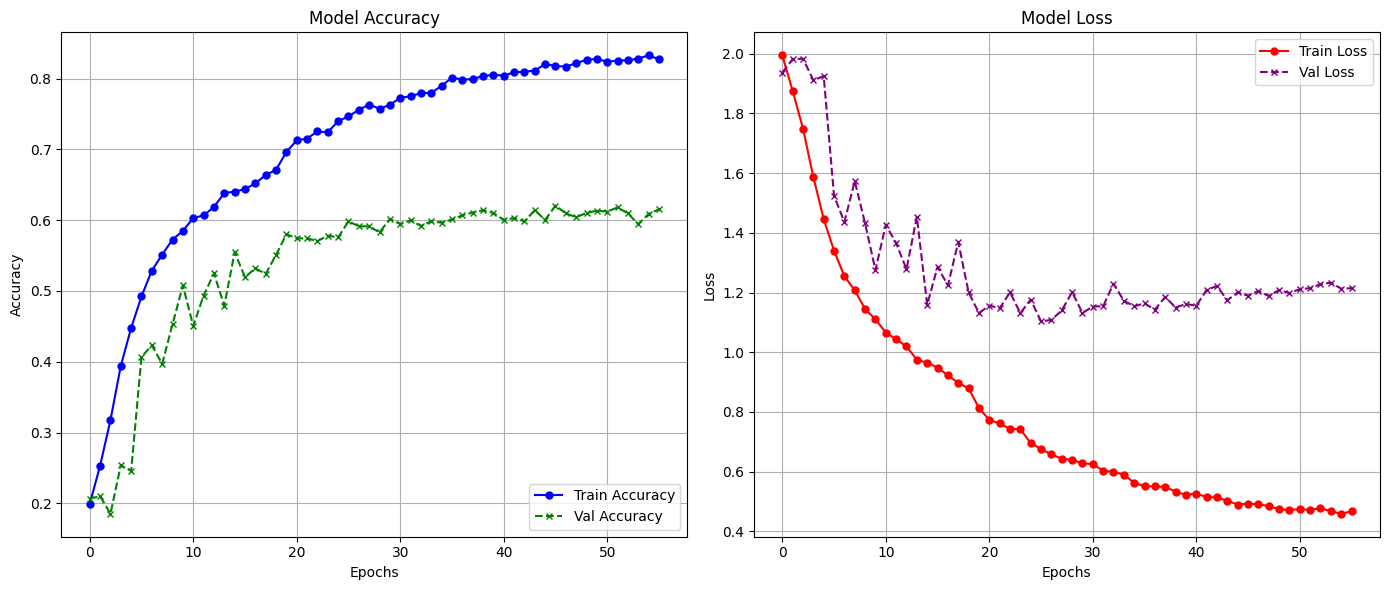

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy
ax1.plot(history_cnn3.history['accuracy'], label='Train Accuracy', color='b', linestyle='-', marker='o', markersize=5)
ax1.plot(history_cnn3.history['val_accuracy'], label='Val Accuracy', color='g', linestyle='--', marker='x', markersize=5)
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot the training and validation loss
ax2.plot(history_cnn3.history['loss'], label='Train Loss', color='r', linestyle='-', marker='o', markersize=5)
ax2.plot(history_cnn3.history['val_loss'], label='Val Loss', color='purple', linestyle='--', marker='x', markersize=5)
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
# Assuming you have test data (X_test, y_test)
test_loss_bl, test_accuracy_bl = model_bl3.evaluate(x_test_reshape_bl, y_test_balanced)
print(f'Test Loss: {test_loss_bl}')
print(f'Test Accuracy: {test_accuracy_bl}')

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6278 - loss: 1.0838
Test Loss: 1.0661410093307495
Test Accuracy: 0.6366580128669739


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Emotion mapping dictionary
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Predict on test data
y_pred_bl = model_bl3.predict(x_test_reshape_bl)
y_pred_classes = y_pred_bl.argmax(axis=1)  # Get the class with max probability

# If your labels are one-hot encoded, convert them using argmax
y_true = y_test_balanced.argmax(axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=emotion_mapping.values()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### 9: Visualisation des Prédictions et Comparaison des Vrais Label

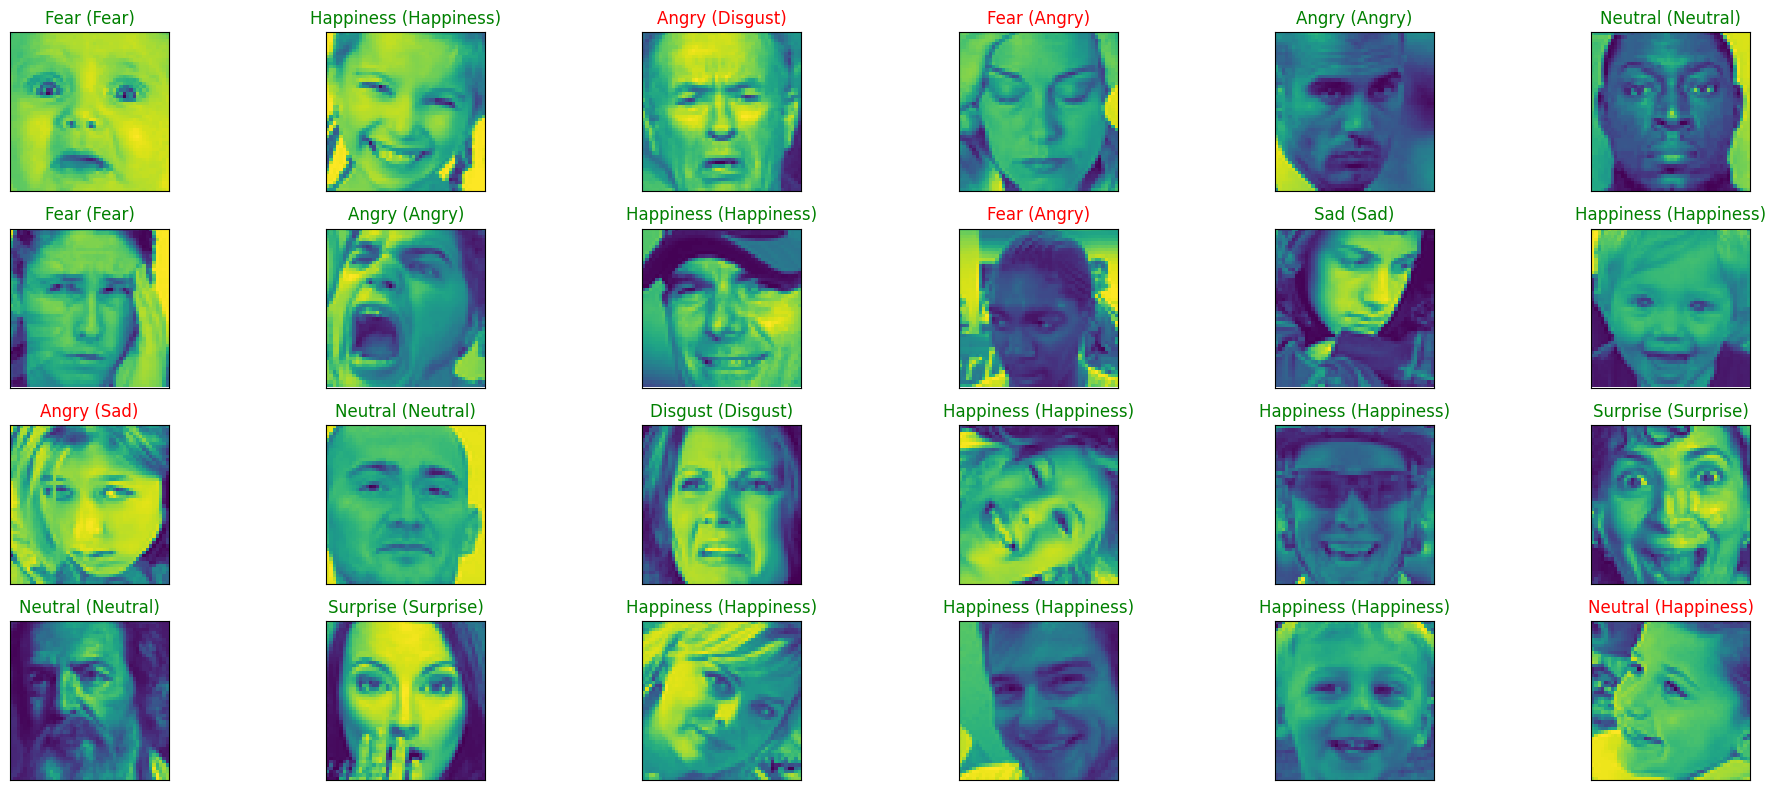

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Create a figure with a size to display 24 images
figure = plt.figure(figsize=(20, 8))

# Ensure the random indices are within the correct bounds
num_samples = x_test_reshape_bl.shape[0]

# Select 24 random indices from the test set, ensuring that the indices do not exceed the available samples
for i, index in enumerate(np.random.choice(num_samples, size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test_reshape_bl[index]))  # Display the image

    # Get the predicted and true labels
    predict_index = label_dict[y_pred_bl[index].argmax()]  # Use .argmax() if y_pred_bl contains probabilities
    true_index = label_dict[np.argmax(y_test_balanced, axis=1)[index]]

    # Set the title of each subplot, using green for correct predictions and red for incorrect
    ax.set_title("{} ({})".format(predict_index, true_index),
                 color="green" if predict_index == true_index else "red")

# Display the plot
plt.tight_layout()
plt.show()


#### 10: Visualisation d'une Image avec Prédictions et Émotions

In [ ]:
import matplotlib.pyplot as plt

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number, emotions):
    """
    Function to plot the image and compare the prediction results with the true label
    Args:
        test_image_array: Array of test images (e.g., x_test_reshape_bl)
        test_image_label: Actual true labels of the test images
        pred_test_labels: Predictions (probabilities) from the model for each image
        image_number: The index of the image to visualize
        emotions: A dictionary that maps label numbers to emotion names (e.g., {0: 'Angry', 1: 'Disgust', ...})
    """

    # Create a subplot with 1 row and 2 columns (for the image and the bar plot)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    # Plot the test image
    axs[0].imshow(test_image_array[image_number], cmap='gray')  # Use 'gray' for grayscale images
    axs[0].set_title(f"True: {emotions[test_image_label[image_number]]}")

    # Plot the predicted probabilities as a bar plot
    bar_labels = list(emotions.values())  # Get the emotion names for the x-axis
    axs[1].bar(bar_labels, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].set_ylabel("Probability")
    axs[1].set_xlabel("Emotion")
    axs[1].set_title("Predicted Probabilities")
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


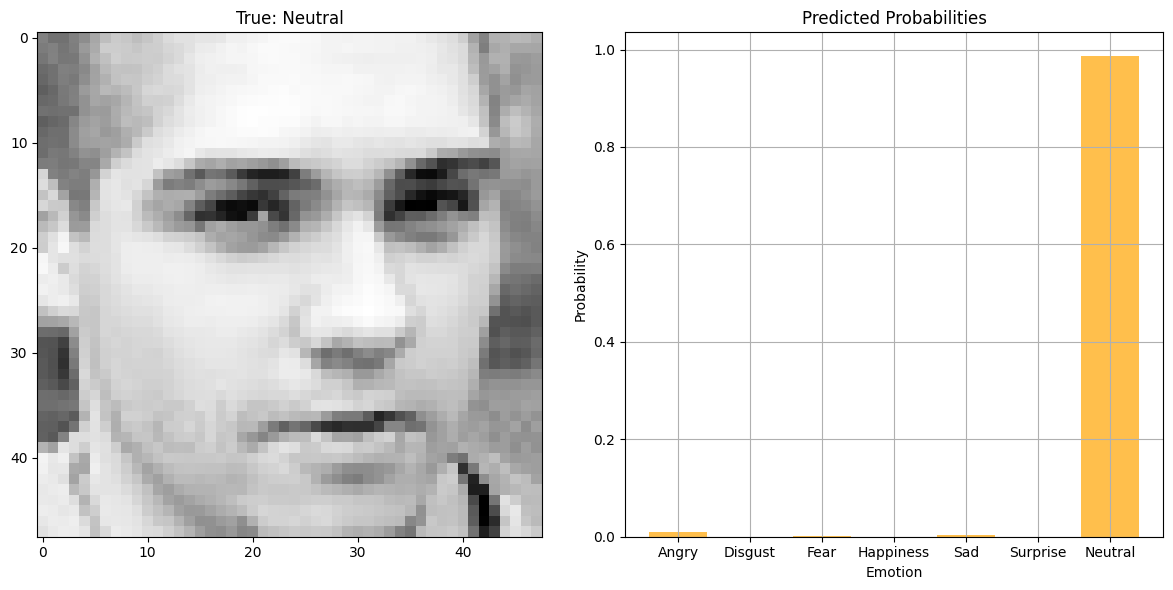

In [ ]:
plot_image_and_emotion(x_test_reshape_bl, y_test_balanced.argmax(axis=1), y_pred_bl, 66,emotions=label_dict)

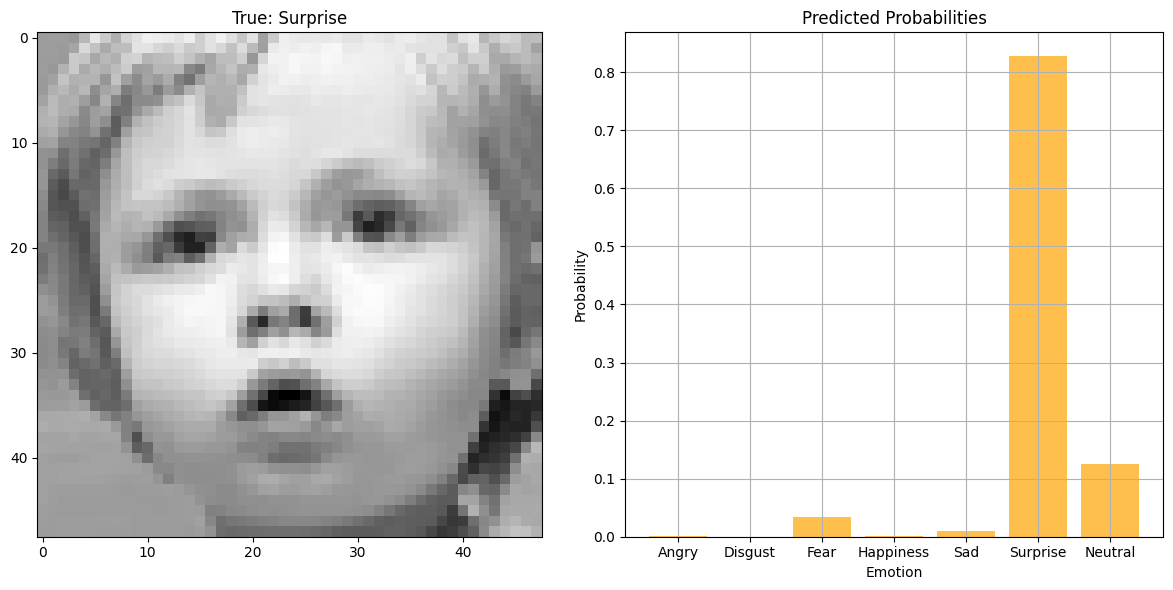

In [ ]:
plot_image_and_emotion(x_test_reshape_bl, y_test_balanced.argmax(axis=1), y_pred_bl, 123,emotions=label_dict)

In [ ]:
# Save the model to a file
model_bl3.save('emotion_recognition_model.keras')

## 6-Comparison

In [3]:
import plotly.express as px
import pandas as pd

# Création des données sous forme de DataFrame
models = ['CNN simple', 'Modification du taux d\'apprentissage et des couches', 'MobileNetV2', 'Augmentation des données et équilibrage des classes']
train_accuracies = [0.5704, 0.3088, 0.24993, 0.8330]
val_accuracies = [0.5754, 0.3502, 0.2196, 0.6206]

# Créer un DataFrame à partir des données
data = {
    'Model': models * 2,  # Répéter les modèles deux fois
    'Accuracy': train_accuracies + val_accuracies,  # Combiner les valeurs d'entraînement et de validation
    'Type': ['Train Accuracy'] * len(models) + ['Validation Accuracy'] * len(models)  # Identifier le type
}

df = pd.DataFrame(data)

# Création du graphique à barres
fig = px.bar(df, x='Model', y='Accuracy', color='Type',
             title="Comparaison des précisions d'entraînement et de validation",
             labels={'Accuracy': 'Précision', 'Model': 'Modèles'},
             barmode='group')  # 'group' pour séparer les barres

# Affichage du graphique
fig.show()


Cette section a exploré différentes architectures pour la reconnaissance des émotions à partir d'images. Le modèle CNN simple a permis d'obtenir des résultats de base raisonnables, mais les ajustements tels que la modification du taux d'apprentissage et des couches ont montré une baisse des performances. Le transfert d'apprentissage avec MobileNetV2 n'a pas non plus donné les résultats escomptés, avec une précision relativement faible. En revanche, l'augmentation des données et l'équilibrage des classes ont permis de maximiser les performances, offrant des précisions significativement meilleures. Cela démontre l'importance de la gestion des données et de leur équilibre pour obtenir un modèle plus robuste et performant.